In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import random
from scipy.stats import ks_2samp
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [2]:
def roundR(x, r):
    return [np.round(i,r) for i in np.array(x)]

In [3]:
def update_weights(model_weights):
  for i in range(len(model_weights)):
    for j in range(len(model_weights[i])):
      if isinstance(model_weights[i][j], np.ndarray):
        for k in range(len(model_weights[i][j])):
          #print("chalra h", i, j, k)
            if (np.round(model_weights[i][j][k],2)==0):
                model_weights[i][j][k]=float(f'{model_weights[i][j][k]:.1g}')
            else:
                model_weights[i][j][k]=np.round(model_weights[i][j][k],2)
      else:
        if (np.round(model_weights[i][j],2)==0):
          model_weights[i][j]=float(f'{model_weights[i][j]:.1g}')
        else:
          model_weights[i][j]=np.round(model_weights[i][j],2)
  return model_weights

In [4]:
def node_comparison1(node1, node2, epsilon=0.05):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if((np.linalg.norm(np.array(x)-np.array(y))/len(x))<=epsilon):
            continue
        else:
            return False
    else:
        if(abs(x-y)<=epsilon):
            continue
        else:
            return False
  return True

In [5]:
def node_comparison(node1, node2):
  for x, y in zip(node1,node2):
    #print(x,y)
    if isinstance(x, list):
        if(sorted(x)==sorted(y)):
            continue
        else:
            return False
    else:
        if(x==y):
            continue
        else:
            return False
  return True

In [6]:
def layer_comparison(layer1, layer2):
  for node1 in layer1:
    present=False
    for node2 in layer2:
      if (node_comparison1(node1, node2)):
        present=True
    if present==False:
      return False
  return True

In [7]:
def check_models(Model_weights1, Model_weights2):
  for i in range(0,len(Model_weights1), 2):
    layer1=[]
    layer2=[]
    for j in range(len(Model_weights1[i+1].T)):
      Node1=[]
      Node2=[]
      Node1.append(list(Model_weights1[i].T[j]))
      Node1.append(Model_weights1[i+1][j])
      if (i+2<len(Model_weights1)):
        Node1.append(list(Model_weights1[i+2][j]))
      Node2.append(list(Model_weights2[i].T[j]))
      Node2.append(Model_weights2[i+1][j])
      if (i+2<len(Model_weights2)):
        Node2.append(list(Model_weights2[i+2][j]))
      layer1.append(Node1)
      layer2.append(Node2)
    if (layer_comparison(layer1, layer2)):
      continue
    else:
      return False
  return True

In [8]:
def get_initial_model(inp, out):
    model = tf.keras.Sequential([
        Dense(5, input_dim=inp, kernel_initializer='normal', activation='relu'),
        Dense(10, activation='relu'),
        Dense(5, activation='relu'),
        Dense(out, activation='softmax')
        ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [25]:
#this function is used to average out all the models in the epsilon range
#the problem is different here than compared with model comparison. Shape not important.
def get_avg_weights(models_weights, inp_shape, out_shape):
    avg_sum=get_initial_model(inp_shape, out_shape).get_weights()
    #print(avg_sum)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                for k in range(len(avg_sum[i][j])):
                    avg_sum[i][j][k]=0
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=0
    #print(avg_sum)
    print(models_weights[0])
    for i in range(len(models_weights)):
        for j in range(0, len(avg_sum),2):
            #print(isinstance(avg_sum[j], np.ndarray))
            #if(isinstance(avg_sum[j][0], np.ndarray)):
            for k in range(len(avg_sum[j])):
                avg_sum[j][k]=[avg_sum[j][k][l]+models_weights[i][j][k][l] for l in range(len(avg_sum[j][k]))]
            #print(isinstance(avg_sum[j], np.ndarray))
            #else: gayab kr diya
            print('andr aara h')
            for k in range(len(avg_sum[j+1])):
                avg_sum[j+1][k]=avg_sum[j+1][k]+models_weights[i][j+1][k]
    print("yhn tk")
    mean_size=len(models_weights)
    print(mean_size)
    for i in range(0,len(avg_sum),2):
        if (i+2<=len(avg_sum)):
            for j in range(len(avg_sum[i])):
                #print("yhn tk")
                avg_sum[i][j]=[avg_sum[i][j][k]/mean_size for k in range(len(avg_sum[i][j]))]
            for j in range(len(avg_sum[i+1])):
                avg_sum[i+1][j]=avg_sum[i+1][j]/mean_size
    print("Done")
    return avg_sum

In [26]:
# custom functions for f1, precision and recall

from keras import backend as K
from keras.utils import to_categorical

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [81]:
#for SKIN_NonSkin dataset
dataset = pd.read_csv("Skin_NonSkin.csv",sep=';', names=['x1','x2','x3','label'])
#print(dataset['label'])
scaler = preprocessing.MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=['x1','x2','x3','label'])
target_variable="label"
print(dataset.head)
Positive=dataset[dataset[target_variable]==0]
Negative=dataset[dataset[target_variable]==1]
print(len(Positive))
print(len(Negative))

<bound method NDFrame.head of               x1        x2        x3  label
0       0.290196  0.333333  0.482353    0.0
1       0.286275  0.329412  0.478431    0.0
2       0.282353  0.325490  0.474510    0.0
3       0.274510  0.317647  0.466667    0.0
4       0.274510  0.317647  0.466667    0.0
...          ...       ...       ...    ...
245052  0.639216  0.635294  0.439216    1.0
245053  0.639216  0.635294  0.439216    1.0
245054  0.639216  0.635294  0.439216    1.0
245055  0.639216  0.635294  0.439216    1.0
245056  1.000000  1.000000  1.000000    1.0

[245057 rows x 4 columns]>
50859
194198


In [82]:
#the below code is for binary classification since MNSIT is a multi-class low-resolution image dataset. I am updating the code in the next cell.
N=1000
#Positive=Pos
#Negative=Neg
positiveN=int((Positive.shape[0]/dataset.shape[0])*N)
negativeN=int(N-positiveN)
print(positiveN, negativeN)
#target variable
#target_variable="default.payment.next.month"
df1=Positive.sample(positiveN)
Positive.drop(df1.index, inplace=True)
df2=Negative.sample(negativeN)
Negative.drop(df2.index, inplace=True)
test_data=df1.append(df2, ignore_index=True)
test_data=test_data.sample(frac = 1) #This is to shuffel the training and testing data
test_data=test_data.sample(frac = 1)
test_data=test_data.sample(frac = 1)
X_test=test_data.drop(columns=[target_variable])
y_test=to_categorical(test_data[target_variable])

# adding dense layer
initial_model= get_initial_model(X_test.shape[1], 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
while Positive.empty==False and Negative.empty==False:
  print(positiveN, negativeN)
  df1=Positive.sample(min(positiveN, len(Positive)))
  Positive.drop(df1.index, inplace=True)
  df2=Negative.sample(min(negativeN, len(Negative)))
  Negative.drop(df2.index, inplace=True)
  train_data=df1.append(df2, ignore_index=True)
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
    
  #all models have different initialization
  # define the sequential model
  """initial_model = keras.Sequential()

    # adding dense layer
  initial_model.add(Dense(5, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
  initial_model.add(Dense(10, activation='relu'))
  initial_model.add(Dense(5, activation='relu'))

    # adding dense layer with softmax activation/output layer
  initial_model.add(Dense(2, activation='softmax'))
  #initial_model.summary()"""
  ann_model=get_initial_model(X_test.shape[1], 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  #train_data[target_variable]=train_data[target_variable]-1 #only for skin_nonskin dataset
  y_train=to_categorical(train_data[target_variable])
  #print(y_train)
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
  print(history.history['f1_m'][-1])
  ann_model.set_weights(update_weights(ann_model.get_weights()))
  pred_test=ann_model.predict(X_test)
  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      val_acc[i].append(history.history['val_f1_m'])
      train_acc[i].append(history.history['f1_m'])
      test_acc[i].append(f1_m(y_test, pred_test).numpy())
      val_loss[i].append(history.history['val_loss'])
      train_loss[i].append(history.history['loss'])
      present=True
      break
  if present==False:
    Models.append([ann_model.get_weights(), 1])
    val_acc.append([history.history['val_f1_m']])
    train_acc.append([history.history['f1_m']])
    test_acc.append([f1_m(y_test, pred_test).numpy()])
    val_loss.append([history.history['val_loss']])
    train_loss.append([history.history['loss']])
for i in range(len(Models)):
  print(Models[i][1])
print("All Done")

207 793


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 686us/sample - loss: 0.6603 - f1_m: 0.7950 - val_loss: 0.6346 - val_f1_m: 0.8080
Epoch 2/20
800/800 [==============================] - 0s 67us/sample - loss: 0.6099 - f1_m: 0.7950 - val_loss: 0.5917 - val_f1_m: 0.7946
Epoch 3/20
800/800 [==============================] - 0s 75us/sample - loss: 0.5686 - f1_m: 0.7950 - val_loss: 0.5578 - val_f1_m: 0.8080
Epoch 4/20
800/800 [==============================] - 0s 66us/sample - loss: 0.5381 - f1_m: 0.7950 - val_loss: 0.5357 - val_f1_m: 0.8080
Epoch 5/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5179 - f1_m: 0.7950 - val_loss: 0.5211 - val_f1_m: 0.7812
Epoch 6/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5030 - f1_m: 0.7950 - val_loss: 0.5075 - val_f1_m: 0.7411
Epoch 7/20
800/800 [==============================] - 0s 64us/sample - loss: 0.4887 - f1_m: 0.7950 - val_loss: 0.4924 - val

Epoch 13/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4062 - f1_m: 0.7962 - val_loss: 0.4086 - val_f1_m: 0.7768
Epoch 14/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3850 - f1_m: 0.7962 - val_loss: 0.3852 - val_f1_m: 0.7500
Epoch 15/20
800/800 [==============================] - 0s 60us/sample - loss: 0.3605 - f1_m: 0.7962 - val_loss: 0.3554 - val_f1_m: 0.7902
Epoch 16/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3350 - f1_m: 0.7962 - val_loss: 0.3277 - val_f1_m: 0.8036
Epoch 17/20
800/800 [==============================] - 0s 62us/sample - loss: 0.3112 - f1_m: 0.7962 - val_loss: 0.3000 - val_f1_m: 0.7634
Epoch 18/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2853 - f1_m: 0.8062 - val_loss: 0.2714 - val_f1_m: 0.8482
Epoch 19/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2633 - f1_m: 0.8712 - val_loss: 0.2516 - val_f1_m: 0.8571
Epoch 20/20
800/800 [=============

800/800 [==============================] - 0s 59us/sample - loss: 0.3459 - f1_m: 0.7925 - val_loss: 0.3273 - val_f1_m: 0.7902
Epoch 17/20
800/800 [==============================] - 0s 65us/sample - loss: 0.3201 - f1_m: 0.7925 - val_loss: 0.3023 - val_f1_m: 0.7902
Epoch 18/20
800/800 [==============================] - 0s 60us/sample - loss: 0.2957 - f1_m: 0.7925 - val_loss: 0.2770 - val_f1_m: 0.8036
Epoch 19/20
800/800 [==============================] - 0s 58us/sample - loss: 0.2711 - f1_m: 0.8737 - val_loss: 0.2541 - val_f1_m: 0.9018
Epoch 20/20
800/800 [==============================] - 0s 60us/sample - loss: 0.2489 - f1_m: 0.9000 - val_loss: 0.2351 - val_f1_m: 0.9330
0.9
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 669us/sample - loss: 0.6570 - f1_m: 0.7987 - val_loss: 0.6402 - val_f1_m: 0.7946
Epoch 2/20
800/800 [==============================] - 0s 60us/sample - loss: 0.6061 - f1_m: 0.7987 - val_loss: 0.6007 - val_f1

Epoch 7/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4946 - f1_m: 0.7887 - val_loss: 0.4616 - val_f1_m: 0.8170
Epoch 8/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4781 - f1_m: 0.7887 - val_loss: 0.4431 - val_f1_m: 0.8170
Epoch 9/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4591 - f1_m: 0.7887 - val_loss: 0.4220 - val_f1_m: 0.8170
Epoch 10/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4368 - f1_m: 0.7887 - val_loss: 0.3988 - val_f1_m: 0.8036
Epoch 11/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4130 - f1_m: 0.7887 - val_loss: 0.3735 - val_f1_m: 0.8304
Epoch 12/20
800/800 [==============================] - 0s 56us/sample - loss: 0.3871 - f1_m: 0.7887 - val_loss: 0.3464 - val_f1_m: 0.7902
Epoch 13/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3590 - f1_m: 0.7887 - val_loss: 0.3178 - val_f1_m: 0.8036
Epoch 14/20
800/800 [================

800/800 [==============================] - 0s 61us/sample - loss: 0.4473 - f1_m: 0.8062 - val_loss: 0.5170 - val_f1_m: 0.7277
Epoch 11/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4325 - f1_m: 0.8062 - val_loss: 0.4997 - val_f1_m: 0.7277
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4153 - f1_m: 0.8062 - val_loss: 0.4803 - val_f1_m: 0.7277
Epoch 13/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3967 - f1_m: 0.8062 - val_loss: 0.4581 - val_f1_m: 0.7277
Epoch 14/20
800/800 [==============================] - 0s 62us/sample - loss: 0.3754 - f1_m: 0.8062 - val_loss: 0.4329 - val_f1_m: 0.7545
Epoch 15/20
800/800 [==============================] - 0s 63us/sample - loss: 0.3525 - f1_m: 0.8062 - val_loss: 0.4032 - val_f1_m: 0.7545
Epoch 16/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3279 - f1_m: 0.8062 - val_loss: 0.3745 - val_f1_m: 0.7545
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 694us/sample - loss: 0.6585 - f1_m: 0.7975 - val_loss: 0.6375 - val_f1_m: 0.7857
Epoch 2/20
800/800 [==============================] - 0s 62us/sample - loss: 0.6070 - f1_m: 0.7975 - val_loss: 0.5964 - val_f1_m: 0.7723
Epoch 3/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5641 - f1_m: 0.7975 - val_loss: 0.5659 - val_f1_m: 0.7589
Epoch 4/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5343 - f1_m: 0.7975 - val_loss: 0.5503 - val_f1_m: 0.7723
Epoch 5/20
800/800 [==============================] - 0s 66us/sample - loss: 0.5164 - f1_m: 0.7975 - val_loss: 0.5406 - val_f1_m: 0.7723
Epoch 6/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5055 - f1_m: 0.7975 - val_loss: 0.5320 - val_f1_m: 0.7723
Epoch 7/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4954 - f1_m: 0.7975 - val_loss: 0.5209 - val_f1_m: 0

Epoch 14/20
800/800 [==============================] - 0s 62us/sample - loss: 0.3970 - f1_m: 0.7962 - val_loss: 0.3963 - val_f1_m: 0.8036
Epoch 15/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3747 - f1_m: 0.7962 - val_loss: 0.3710 - val_f1_m: 0.7902
Epoch 16/20
800/800 [==============================] - 0s 60us/sample - loss: 0.3500 - f1_m: 0.7962 - val_loss: 0.3440 - val_f1_m: 0.7500
Epoch 17/20
800/800 [==============================] - 0s 61us/sample - loss: 0.3242 - f1_m: 0.7962 - val_loss: 0.3164 - val_f1_m: 0.7500
Epoch 18/20
800/800 [==============================] - 0s 60us/sample - loss: 0.2993 - f1_m: 0.7962 - val_loss: 0.2878 - val_f1_m: 0.8036
Epoch 19/20
800/800 [==============================] - 0s 58us/sample - loss: 0.2751 - f1_m: 0.8400 - val_loss: 0.2650 - val_f1_m: 0.8929
Epoch 20/20
800/800 [==============================] - 0s 60us/sample - loss: 0.2536 - f1_m: 0.8737 - val_loss: 0.2405 - val_f1_m: 0.9241
0.8737499
if any
207 793
Train on 

800/800 [==============================] - 0s 57us/sample - loss: 0.2892 - f1_m: 0.7962 - val_loss: 0.3088 - val_f1_m: 0.7411
Epoch 18/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2647 - f1_m: 0.8875 - val_loss: 0.2886 - val_f1_m: 0.8393
Epoch 19/20
800/800 [==============================] - 0s 58us/sample - loss: 0.2420 - f1_m: 0.8850 - val_loss: 0.2692 - val_f1_m: 0.9018
Epoch 20/20
800/800 [==============================] - 0s 66us/sample - loss: 0.2204 - f1_m: 0.9100 - val_loss: 0.2527 - val_f1_m: 0.8973
0.9099999
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 756us/sample - loss: 0.6569 - f1_m: 0.7900 - val_loss: 0.6279 - val_f1_m: 0.7991
Epoch 2/20
800/800 [==============================] - 0s 75us/sample - loss: 0.6093 - f1_m: 0.7900 - val_loss: 0.5779 - val_f1_m: 0.8259
Epoch 3/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5659 - f1_m: 0.7900 - val_loss: 0.5

800/800 [==============================] - 0s 56us/sample - loss: 0.1727 - f1_m: 0.9513 - val_loss: 0.2015 - val_f1_m: 0.9375
0.95125
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 666us/sample - loss: 0.6608 - f1_m: 0.7912 - val_loss: 0.6329 - val_f1_m: 0.8214
Epoch 2/20
800/800 [==============================] - 0s 61us/sample - loss: 0.6143 - f1_m: 0.7912 - val_loss: 0.5895 - val_f1_m: 0.8080
Epoch 3/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5761 - f1_m: 0.7912 - val_loss: 0.5542 - val_f1_m: 0.8214
Epoch 4/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5484 - f1_m: 0.7912 - val_loss: 0.5303 - val_f1_m: 0.8080
Epoch 5/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5306 - f1_m: 0.7912 - val_loss: 0.5148 - val_f1_m: 0.7812
Epoch 6/20
800/800 [==============================] - 0s 58us/sample - loss: 0.5167 - f1_m: 0.7912 - val_loss: 0.5024 -

Epoch 11/20
800/800 [==============================] - 0s 64us/sample - loss: 0.4029 - f1_m: 0.7887 - val_loss: 0.3708 - val_f1_m: 0.8036
Epoch 12/20
800/800 [==============================] - 0s 65us/sample - loss: 0.3770 - f1_m: 0.7887 - val_loss: 0.3459 - val_f1_m: 0.8036
Epoch 13/20
800/800 [==============================] - 0s 62us/sample - loss: 0.3497 - f1_m: 0.7887 - val_loss: 0.3196 - val_f1_m: 0.8036
Epoch 14/20
800/800 [==============================] - 0s 65us/sample - loss: 0.3214 - f1_m: 0.7887 - val_loss: 0.2932 - val_f1_m: 0.8036
Epoch 15/20
800/800 [==============================] - 0s 62us/sample - loss: 0.2944 - f1_m: 0.8012 - val_loss: 0.2671 - val_f1_m: 0.8482
Epoch 16/20
800/800 [==============================] - 0s 64us/sample - loss: 0.2676 - f1_m: 0.8762 - val_loss: 0.2437 - val_f1_m: 0.8795
Epoch 17/20
800/800 [==============================] - 0s 65us/sample - loss: 0.2444 - f1_m: 0.9025 - val_loss: 0.2225 - val_f1_m: 0.9062
Epoch 18/20
800/800 [=============

800/800 [==============================] - 0s 55us/sample - loss: 0.3723 - f1_m: 0.7950 - val_loss: 0.3636 - val_f1_m: 0.7812
Epoch 15/20
800/800 [==============================] - 0s 55us/sample - loss: 0.3417 - f1_m: 0.7950 - val_loss: 0.3316 - val_f1_m: 0.7946
Epoch 16/20
800/800 [==============================] - 0s 55us/sample - loss: 0.3100 - f1_m: 0.7950 - val_loss: 0.2985 - val_f1_m: 0.7545
Epoch 17/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2783 - f1_m: 0.8137 - val_loss: 0.2670 - val_f1_m: 0.8884
Epoch 18/20
800/800 [==============================] - 0s 56us/sample - loss: 0.2492 - f1_m: 0.8937 - val_loss: 0.2391 - val_f1_m: 0.9062
Epoch 19/20
800/800 [==============================] - 0s 56us/sample - loss: 0.2230 - f1_m: 0.9200 - val_loss: 0.2152 - val_f1_m: 0.9196
Epoch 20/20
800/800 [==============================] - 0s 58us/sample - loss: 0.2017 - f1_m: 0.9325 - val_loss: 0.1960 - val_f1_m: 0.9554
0.93249995
if any
207 793
Train on 800 samples

800/800 [==============================] - 0s 62us/sample - loss: 0.2742 - f1_m: 0.8612 - val_loss: 0.2605 - val_f1_m: 0.8259
Epoch 18/20
800/800 [==============================] - 0s 65us/sample - loss: 0.2489 - f1_m: 0.9012 - val_loss: 0.2437 - val_f1_m: 0.8839
Epoch 19/20
800/800 [==============================] - 0s 55us/sample - loss: 0.2252 - f1_m: 0.9050 - val_loss: 0.2308 - val_f1_m: 0.8839
Epoch 20/20
800/800 [==============================] - 0s 57us/sample - loss: 0.2085 - f1_m: 0.9300 - val_loss: 0.2231 - val_f1_m: 0.8393
0.93
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 681us/sample - loss: 0.6548 - f1_m: 0.7975 - val_loss: 0.6332 - val_f1_m: 0.7991
Epoch 2/20
800/800 [==============================] - 0s 62us/sample - loss: 0.6053 - f1_m: 0.7975 - val_loss: 0.5893 - val_f1_m: 0.7723
Epoch 3/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5594 - f1_m: 0.7975 - val_loss: 0.5584 -

Epoch 8/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4820 - f1_m: 0.7887 - val_loss: 0.4437 - val_f1_m: 0.7902
Epoch 9/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4629 - f1_m: 0.7887 - val_loss: 0.4249 - val_f1_m: 0.8036
Epoch 10/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4415 - f1_m: 0.7887 - val_loss: 0.4005 - val_f1_m: 0.7902
Epoch 11/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4170 - f1_m: 0.7887 - val_loss: 0.3737 - val_f1_m: 0.8170
Epoch 12/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3900 - f1_m: 0.7887 - val_loss: 0.3441 - val_f1_m: 0.8170
Epoch 13/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3596 - f1_m: 0.7887 - val_loss: 0.3124 - val_f1_m: 0.7768
Epoch 14/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3279 - f1_m: 0.7887 - val_loss: 0.2796 - val_f1_m: 0.7902
Epoch 15/20
800/800 [===============

if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 665us/sample - loss: 0.6584 - f1_m: 0.7937 - val_loss: 0.6314 - val_f1_m: 0.7991
Epoch 2/20
800/800 [==============================] - 0s 61us/sample - loss: 0.6101 - f1_m: 0.7937 - val_loss: 0.5860 - val_f1_m: 0.7857
Epoch 3/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5674 - f1_m: 0.7937 - val_loss: 0.5509 - val_f1_m: 0.8125
Epoch 4/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5393 - f1_m: 0.7937 - val_loss: 0.5283 - val_f1_m: 0.7991
Epoch 5/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5199 - f1_m: 0.7937 - val_loss: 0.5167 - val_f1_m: 0.7991
Epoch 6/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5078 - f1_m: 0.7937 - val_loss: 0.5062 - val_f1_m: 0.7991
Epoch 7/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4980 - f1_m: 0.7937 - val_loss: 0.495

800/800 [==============================] - 0s 62us/sample - loss: 0.6078 - f1_m: 0.7950 - val_loss: 0.5863 - val_f1_m: 0.7946
Epoch 3/20
800/800 [==============================] - 0s 66us/sample - loss: 0.5646 - f1_m: 0.7950 - val_loss: 0.5508 - val_f1_m: 0.7812
Epoch 4/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5347 - f1_m: 0.7950 - val_loss: 0.5306 - val_f1_m: 0.7946
Epoch 5/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5176 - f1_m: 0.7950 - val_loss: 0.5187 - val_f1_m: 0.7946
Epoch 6/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5068 - f1_m: 0.7950 - val_loss: 0.5089 - val_f1_m: 0.7812
Epoch 7/20
800/800 [==============================] - 0s 63us/sample - loss: 0.4962 - f1_m: 0.7950 - val_loss: 0.4958 - val_f1_m: 0.7812
Epoch 8/20
800/800 [==============================] - 0s 62us/sample - loss: 0.4821 - f1_m: 0.7950 - val_loss: 0.4792 - val_f1_m: 0.7679
Epoch 9/20
800/800 [==============================] 

800/800 [==============================] - 0s 60us/sample - loss: 0.5188 - f1_m: 0.7925 - val_loss: 0.5061 - val_f1_m: 0.8170
Epoch 6/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5064 - f1_m: 0.7925 - val_loss: 0.4950 - val_f1_m: 0.7902
Epoch 7/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4945 - f1_m: 0.7925 - val_loss: 0.4825 - val_f1_m: 0.8036
Epoch 8/20
800/800 [==============================] - 0s 62us/sample - loss: 0.4811 - f1_m: 0.7925 - val_loss: 0.4687 - val_f1_m: 0.7500
Epoch 9/20
800/800 [==============================] - ETA: 0s - loss: 0.4486 - f1_m: 0.81 - 0s 60us/sample - loss: 0.4650 - f1_m: 0.7925 - val_loss: 0.4529 - val_f1_m: 0.7768
Epoch 10/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4483 - f1_m: 0.7925 - val_loss: 0.4342 - val_f1_m: 0.8170
Epoch 11/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4287 - f1_m: 0.7925 - val_loss: 0.4138 - val_f1_m: 0.7768
Epoch 12/20


800/800 [==============================] - 0s 57us/sample - loss: 0.4817 - f1_m: 0.7987 - val_loss: 0.5076 - val_f1_m: 0.7679
Epoch 9/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4687 - f1_m: 0.7987 - val_loss: 0.4936 - val_f1_m: 0.7679
Epoch 10/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4539 - f1_m: 0.7987 - val_loss: 0.4775 - val_f1_m: 0.7812
Epoch 11/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4377 - f1_m: 0.7987 - val_loss: 0.4599 - val_f1_m: 0.7679
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4200 - f1_m: 0.7987 - val_loss: 0.4389 - val_f1_m: 0.7679
Epoch 13/20
800/800 [==============================] - 0s 61us/sample - loss: 0.3996 - f1_m: 0.7987 - val_loss: 0.4176 - val_f1_m: 0.7545
Epoch 14/20
800/800 [==============================] - 0s 60us/sample - loss: 0.3766 - f1_m: 0.7987 - val_loss: 0.3899 - val_f1_m: 0.7679
Epoch 15/20
800/800 [==========================

if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 680us/sample - loss: 0.6552 - f1_m: 0.8062 - val_loss: 0.6451 - val_f1_m: 0.7277
Epoch 2/20
800/800 [==============================] - 0s 61us/sample - loss: 0.6006 - f1_m: 0.8062 - val_loss: 0.6114 - val_f1_m: 0.7545
Epoch 3/20
800/800 [==============================] - 0s 68us/sample - loss: 0.5538 - f1_m: 0.8062 - val_loss: 0.5904 - val_f1_m: 0.7545
Epoch 4/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5223 - f1_m: 0.8062 - val_loss: 0.5827 - val_f1_m: 0.7143
Epoch 5/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5054 - f1_m: 0.8062 - val_loss: 0.5785 - val_f1_m: 0.7411
Epoch 6/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4939 - f1_m: 0.8062 - val_loss: 0.5717 - val_f1_m: 0.7545
Epoch 7/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4837 - f1_m: 0.8062 - val_loss: 0.561

Epoch 13/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3876 - f1_m: 0.7887 - val_loss: 0.3448 - val_f1_m: 0.8304
Epoch 14/20
800/800 [==============================] - 0s 67us/sample - loss: 0.3542 - f1_m: 0.7887 - val_loss: 0.3114 - val_f1_m: 0.8304
Epoch 15/20
800/800 [==============================] - 0s 63us/sample - loss: 0.3201 - f1_m: 0.7887 - val_loss: 0.2764 - val_f1_m: 0.8170
Epoch 16/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2861 - f1_m: 0.7900 - val_loss: 0.2449 - val_f1_m: 0.8616
Epoch 17/20
800/800 [==============================] - 0s 60us/sample - loss: 0.2537 - f1_m: 0.8862 - val_loss: 0.2162 - val_f1_m: 0.9464
Epoch 18/20
800/800 [==============================] - 0s 58us/sample - loss: 0.2245 - f1_m: 0.9275 - val_loss: 0.1890 - val_f1_m: 0.9330
Epoch 19/20
800/800 [==============================] - 0s 62us/sample - loss: 0.1997 - f1_m: 0.9413 - val_loss: 0.1685 - val_f1_m: 0.9554
Epoch 20/20
800/800 [=============

Epoch 17/20
800/800 [==============================] - 0s 61us/sample - loss: 0.2988 - f1_m: 0.7850 - val_loss: 0.2709 - val_f1_m: 0.8482
Epoch 18/20
800/800 [==============================] - 0s 58us/sample - loss: 0.2734 - f1_m: 0.8662 - val_loss: 0.2524 - val_f1_m: 0.8795
Epoch 19/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2496 - f1_m: 0.9087 - val_loss: 0.2333 - val_f1_m: 0.9062
Epoch 20/20
800/800 [==============================] - 0s 61us/sample - loss: 0.2290 - f1_m: 0.9150 - val_loss: 0.2192 - val_f1_m: 0.9152
0.915
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 685us/sample - loss: 0.6569 - f1_m: 0.7912 - val_loss: 0.6294 - val_f1_m: 0.8214
Epoch 2/20
800/800 [==============================] - 0s 62us/sample - loss: 0.6076 - f1_m: 0.7912 - val_loss: 0.5816 - val_f1_m: 0.7812
Epoch 3/20
800/800 [==============================] - 0s 67us/sample - loss: 0.5667 - f1_m: 0.7912 - val_l

800/800 [==============================] - 0s 58us/sample - loss: 0.1794 - f1_m: 0.9413 - val_loss: 0.1919 - val_f1_m: 0.9062
0.94125
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 684us/sample - loss: 0.6584 - f1_m: 0.7887 - val_loss: 0.6266 - val_f1_m: 0.8125
Epoch 2/20
800/800 [==============================] - 0s 61us/sample - loss: 0.6098 - f1_m: 0.7900 - val_loss: 0.5763 - val_f1_m: 0.7991
Epoch 3/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5685 - f1_m: 0.7900 - val_loss: 0.5341 - val_f1_m: 0.7857
Epoch 4/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5401 - f1_m: 0.7900 - val_loss: 0.5096 - val_f1_m: 0.7857
Epoch 5/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5232 - f1_m: 0.7900 - val_loss: 0.4949 - val_f1_m: 0.8125
Epoch 6/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5119 - f1_m: 0.7900 - val_loss: 0.4837 -

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 683us/sample - loss: 0.6581 - f1_m: 0.7900 - val_loss: 0.6319 - val_f1_m: 0.7768
Epoch 2/20
800/800 [==============================] - 0s 70us/sample - loss: 0.6088 - f1_m: 0.7925 - val_loss: 0.5866 - val_f1_m: 0.8170
Epoch 3/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5676 - f1_m: 0.7925 - val_loss: 0.5487 - val_f1_m: 0.7902
Epoch 4/20
800/800 [==============================] - 0s 66us/sample - loss: 0.5388 - f1_m: 0.7925 - val_loss: 0.5265 - val_f1_m: 0.7768
Epoch 5/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5210 - f1_m: 0.7925 - val_loss: 0.5136 - val_f1_m: 0.7902
Epoch 6/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5104 - f1_m: 0.7925 - val_loss: 0.5038 - val_f1_m: 0.8036
Epoch 7/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5007 - f1_m: 0.7925 - val_loss: 0.4937 - val_f1_m: 0

800/800 [==============================] - 0s 63us/sample - loss: 0.5417 - f1_m: 0.7875 - val_loss: 0.5086 - val_f1_m: 0.8080
Epoch 5/20
800/800 [==============================] - 0s 66us/sample - loss: 0.5267 - f1_m: 0.7875 - val_loss: 0.4929 - val_f1_m: 0.7946
Epoch 6/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5159 - f1_m: 0.7875 - val_loss: 0.4816 - val_f1_m: 0.7946
Epoch 7/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5068 - f1_m: 0.7875 - val_loss: 0.4705 - val_f1_m: 0.8080
Epoch 8/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4965 - f1_m: 0.7875 - val_loss: 0.4592 - val_f1_m: 0.7946
Epoch 9/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4832 - f1_m: 0.7875 - val_loss: 0.4463 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4696 - f1_m: 0.7875 - val_loss: 0.4313 - val_f1_m: 0.8214
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 59us/sample - loss: 0.5020 - f1_m: 0.7875 - val_loss: 0.4667 - val_f1_m: 0.8348
Epoch 8/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4894 - f1_m: 0.7875 - val_loss: 0.4534 - val_f1_m: 0.8080
Epoch 9/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4748 - f1_m: 0.7875 - val_loss: 0.4380 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4589 - f1_m: 0.7875 - val_loss: 0.4202 - val_f1_m: 0.8214
Epoch 11/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4405 - f1_m: 0.7875 - val_loss: 0.4006 - val_f1_m: 0.8214
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4199 - f1_m: 0.7875 - val_loss: 0.3789 - val_f1_m: 0.7946
Epoch 13/20
800/800 [==============================] - 0s 62us/sample - loss: 0.3967 - f1_m: 0.7875 - val_loss: 0.3553 - val_f1_m: 0.8214
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 58us/sample - loss: 0.4506 - f1_m: 0.7862 - val_loss: 0.4096 - val_f1_m: 0.8125
Epoch 11/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4294 - f1_m: 0.7862 - val_loss: 0.3893 - val_f1_m: 0.7991
Epoch 12/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4061 - f1_m: 0.7862 - val_loss: 0.3678 - val_f1_m: 0.8259
Epoch 13/20
800/800 [==============================] - 0s 61us/sample - loss: 0.3817 - f1_m: 0.7862 - val_loss: 0.3458 - val_f1_m: 0.8125
Epoch 14/20
800/800 [==============================] - 0s 61us/sample - loss: 0.3547 - f1_m: 0.7862 - val_loss: 0.3217 - val_f1_m: 0.7857
Epoch 15/20
800/800 [==============================] - 0s 62us/sample - loss: 0.3266 - f1_m: 0.7862 - val_loss: 0.2988 - val_f1_m: 0.8125
Epoch 16/20
800/800 [==============================] - 0s 67us/sample - loss: 0.2983 - f1_m: 0.7862 - val_loss: 0.2757 - val_f1_m: 0.8661
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 682us/sample - loss: 0.6590 - f1_m: 0.7837 - val_loss: 0.6235 - val_f1_m: 0.8080
Epoch 2/20
800/800 [==============================] - 0s 63us/sample - loss: 0.6116 - f1_m: 0.7837 - val_loss: 0.5708 - val_f1_m: 0.8482
Epoch 3/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5726 - f1_m: 0.7837 - val_loss: 0.5254 - val_f1_m: 0.8348
Epoch 4/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5430 - f1_m: 0.7837 - val_loss: 0.4948 - val_f1_m: 0.8482
Epoch 5/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5267 - f1_m: 0.7837 - val_loss: 0.4734 - val_f1_m: 0.8348
Epoch 6/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5099 - f1_m: 0.7837 - val_loss: 0.4574 - val_f1_m: 0.8348
Epoch 7/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4946 - f1_m: 0.7837 - val_loss: 0.4401 - val_f1_m: 0

800/800 [==============================] - 0s 64us/sample - loss: 0.5405 - f1_m: 0.7887 - val_loss: 0.5137 - val_f1_m: 0.8170
Epoch 5/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5235 - f1_m: 0.7887 - val_loss: 0.5005 - val_f1_m: 0.8304
Epoch 6/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5136 - f1_m: 0.7887 - val_loss: 0.4887 - val_f1_m: 0.8170
Epoch 7/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5036 - f1_m: 0.7887 - val_loss: 0.4788 - val_f1_m: 0.8304
Epoch 8/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4927 - f1_m: 0.7887 - val_loss: 0.4665 - val_f1_m: 0.8170
Epoch 9/20
800/800 [==============================] - 0s 63us/sample - loss: 0.4796 - f1_m: 0.7887 - val_loss: 0.4520 - val_f1_m: 0.7902
Epoch 10/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4653 - f1_m: 0.7887 - val_loss: 0.4370 - val_f1_m: 0.8304
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 59us/sample - loss: 0.4935 - f1_m: 0.7950 - val_loss: 0.4993 - val_f1_m: 0.7679
Epoch 8/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4818 - f1_m: 0.7950 - val_loss: 0.4872 - val_f1_m: 0.7679
Epoch 9/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4693 - f1_m: 0.7950 - val_loss: 0.4727 - val_f1_m: 0.7946
Epoch 10/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4543 - f1_m: 0.7950 - val_loss: 0.4582 - val_f1_m: 0.7946
Epoch 11/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4384 - f1_m: 0.7950 - val_loss: 0.4416 - val_f1_m: 0.8080
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4205 - f1_m: 0.7950 - val_loss: 0.4227 - val_f1_m: 0.7812
Epoch 13/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4005 - f1_m: 0.7950 - val_loss: 0.4000 - val_f1_m: 0.7679
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 58us/sample - loss: 0.4534 - f1_m: 0.7937 - val_loss: 0.4483 - val_f1_m: 0.7857
Epoch 11/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4312 - f1_m: 0.7937 - val_loss: 0.4252 - val_f1_m: 0.7857
Epoch 12/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4071 - f1_m: 0.7937 - val_loss: 0.3984 - val_f1_m: 0.7991
Epoch 13/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3786 - f1_m: 0.7937 - val_loss: 0.3690 - val_f1_m: 0.7723
Epoch 14/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3496 - f1_m: 0.7937 - val_loss: 0.3386 - val_f1_m: 0.7723
Epoch 15/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3203 - f1_m: 0.7937 - val_loss: 0.3087 - val_f1_m: 0.8125
Epoch 16/20
800/800 [==============================] - 0s 55us/sample - loss: 0.2900 - f1_m: 0.7937 - val_loss: 0.2797 - val_f1_m: 0.7946
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 683us/sample - loss: 0.6586 - f1_m: 0.7912 - val_loss: 0.6323 - val_f1_m: 0.8214
Epoch 2/20
800/800 [==============================] - 0s 64us/sample - loss: 0.6088 - f1_m: 0.7912 - val_loss: 0.5864 - val_f1_m: 0.8080
Epoch 3/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5666 - f1_m: 0.7912 - val_loss: 0.5488 - val_f1_m: 0.7679
Epoch 4/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5386 - f1_m: 0.7912 - val_loss: 0.5270 - val_f1_m: 0.8080
Epoch 5/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5247 - f1_m: 0.7912 - val_loss: 0.5135 - val_f1_m: 0.8214
Epoch 6/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5125 - f1_m: 0.7912 - val_loss: 0.5037 - val_f1_m: 0.8080
Epoch 7/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5021 - f1_m: 0.7912 - val_loss: 0.4927 - val_f1_m: 0

800/800 [==============================] - 0s 65us/sample - loss: 0.5500 - f1_m: 0.7800 - val_loss: 0.4791 - val_f1_m: 0.8482
Epoch 5/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5347 - f1_m: 0.7800 - val_loss: 0.4582 - val_f1_m: 0.8348
Epoch 6/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5226 - f1_m: 0.7800 - val_loss: 0.4440 - val_f1_m: 0.8348
Epoch 7/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5107 - f1_m: 0.7800 - val_loss: 0.4294 - val_f1_m: 0.8214
Epoch 8/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4967 - f1_m: 0.7800 - val_loss: 0.4155 - val_f1_m: 0.8616
Epoch 9/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4796 - f1_m: 0.7800 - val_loss: 0.3968 - val_f1_m: 0.8482
Epoch 10/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4593 - f1_m: 0.7800 - val_loss: 0.3751 - val_f1_m: 0.8482
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 59us/sample - loss: 0.5018 - f1_m: 0.7862 - val_loss: 0.4514 - val_f1_m: 0.8125
Epoch 8/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4852 - f1_m: 0.7862 - val_loss: 0.4333 - val_f1_m: 0.8393
Epoch 9/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4664 - f1_m: 0.7862 - val_loss: 0.4146 - val_f1_m: 0.8125
Epoch 10/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4458 - f1_m: 0.7862 - val_loss: 0.3953 - val_f1_m: 0.8259
Epoch 11/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4221 - f1_m: 0.7862 - val_loss: 0.3716 - val_f1_m: 0.8393
Epoch 12/20
800/800 [==============================] - 0s 55us/sample - loss: 0.3947 - f1_m: 0.7862 - val_loss: 0.3472 - val_f1_m: 0.8125
Epoch 13/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3659 - f1_m: 0.7862 - val_loss: 0.3246 - val_f1_m: 0.8393
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 57us/sample - loss: 0.4587 - f1_m: 0.7975 - val_loss: 0.4811 - val_f1_m: 0.7455
Epoch 11/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4440 - f1_m: 0.7975 - val_loss: 0.4650 - val_f1_m: 0.7857
Epoch 12/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4285 - f1_m: 0.7975 - val_loss: 0.4486 - val_f1_m: 0.7723
Epoch 13/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4107 - f1_m: 0.7975 - val_loss: 0.4266 - val_f1_m: 0.7321
Epoch 14/20
800/800 [==============================] - 0s 57us/sample - loss: 0.3892 - f1_m: 0.7975 - val_loss: 0.4044 - val_f1_m: 0.7857
Epoch 15/20
800/800 [==============================] - 0s 57us/sample - loss: 0.3669 - f1_m: 0.7975 - val_loss: 0.3830 - val_f1_m: 0.7723
Epoch 16/20
800/800 [==============================] - 0s 55us/sample - loss: 0.3434 - f1_m: 0.7975 - val_loss: 0.3558 - val_f1_m: 0.7857
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 696us/sample - loss: 0.6589 - f1_m: 0.8000 - val_loss: 0.6404 - val_f1_m: 0.7768
Epoch 2/20
800/800 [==============================] - 0s 61us/sample - loss: 0.6073 - f1_m: 0.8000 - val_loss: 0.6020 - val_f1_m: 0.7500
Epoch 3/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5612 - f1_m: 0.8000 - val_loss: 0.5724 - val_f1_m: 0.7634
Epoch 4/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5291 - f1_m: 0.8000 - val_loss: 0.5567 - val_f1_m: 0.7500
Epoch 5/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5102 - f1_m: 0.8000 - val_loss: 0.5468 - val_f1_m: 0.7500
Epoch 6/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4986 - f1_m: 0.8000 - val_loss: 0.5390 - val_f1_m: 0.7634
Epoch 7/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4874 - f1_m: 0.8000 - val_loss: 0.5278 - val_f1_m: 0

800/800 [==============================] - 0s 64us/sample - loss: 0.5399 - f1_m: 0.7887 - val_loss: 0.5072 - val_f1_m: 0.8036
Epoch 5/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5237 - f1_m: 0.7887 - val_loss: 0.4929 - val_f1_m: 0.7902
Epoch 6/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5131 - f1_m: 0.7887 - val_loss: 0.4816 - val_f1_m: 0.7902
Epoch 7/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5033 - f1_m: 0.7887 - val_loss: 0.4708 - val_f1_m: 0.8170
Epoch 8/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4919 - f1_m: 0.7887 - val_loss: 0.4590 - val_f1_m: 0.8036
Epoch 9/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4782 - f1_m: 0.7887 - val_loss: 0.4449 - val_f1_m: 0.8170
Epoch 10/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4637 - f1_m: 0.7887 - val_loss: 0.4298 - val_f1_m: 0.7902
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 54us/sample - loss: 0.4902 - f1_m: 0.8000 - val_loss: 0.5336 - val_f1_m: 0.7500
Epoch 8/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4794 - f1_m: 0.8000 - val_loss: 0.5200 - val_f1_m: 0.7902
Epoch 9/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4672 - f1_m: 0.8000 - val_loss: 0.5053 - val_f1_m: 0.7902
Epoch 10/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4522 - f1_m: 0.8000 - val_loss: 0.4904 - val_f1_m: 0.7768
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4370 - f1_m: 0.8000 - val_loss: 0.4746 - val_f1_m: 0.7500
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4192 - f1_m: 0.8000 - val_loss: 0.4538 - val_f1_m: 0.7768
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3988 - f1_m: 0.8000 - val_loss: 0.4315 - val_f1_m: 0.7500
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 59us/sample - loss: 0.4615 - f1_m: 0.7925 - val_loss: 0.4484 - val_f1_m: 0.8170
Epoch 11/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4452 - f1_m: 0.7925 - val_loss: 0.4308 - val_f1_m: 0.8036
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4266 - f1_m: 0.7925 - val_loss: 0.4102 - val_f1_m: 0.7902
Epoch 13/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4056 - f1_m: 0.7925 - val_loss: 0.3875 - val_f1_m: 0.7902
Epoch 14/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3821 - f1_m: 0.7925 - val_loss: 0.3628 - val_f1_m: 0.8036
Epoch 15/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3564 - f1_m: 0.7925 - val_loss: 0.3360 - val_f1_m: 0.8170
Epoch 16/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3291 - f1_m: 0.7925 - val_loss: 0.3095 - val_f1_m: 0.8036
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 682us/sample - loss: 0.6557 - f1_m: 0.7937 - val_loss: 0.6328 - val_f1_m: 0.8125
Epoch 2/20
800/800 [==============================] - 0s 62us/sample - loss: 0.6081 - f1_m: 0.7937 - val_loss: 0.5878 - val_f1_m: 0.7857
Epoch 3/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5634 - f1_m: 0.7937 - val_loss: 0.5535 - val_f1_m: 0.8125
Epoch 4/20
800/800 [==============================] - 0s 68us/sample - loss: 0.5341 - f1_m: 0.7937 - val_loss: 0.5335 - val_f1_m: 0.7723
Epoch 5/20
800/800 [==============================] - 0s 83us/sample - loss: 0.5165 - f1_m: 0.7937 - val_loss: 0.5226 - val_f1_m: 0.7991
Epoch 6/20
800/800 [==============================] - 0s 66us/sample - loss: 0.5062 - f1_m: 0.7937 - val_loss: 0.5133 - val_f1_m: 0.7991
Epoch 7/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4966 - f1_m: 0.7937 - val_loss: 0.5037 - val_f1_m: 0

800/800 [==============================] - 0s 64us/sample - loss: 0.5470 - f1_m: 0.7887 - val_loss: 0.5226 - val_f1_m: 0.8036
Epoch 5/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5325 - f1_m: 0.7887 - val_loss: 0.5080 - val_f1_m: 0.8036
Epoch 6/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5229 - f1_m: 0.7887 - val_loss: 0.4995 - val_f1_m: 0.8304
Epoch 7/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5168 - f1_m: 0.7887 - val_loss: 0.4915 - val_f1_m: 0.8036
Epoch 8/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5101 - f1_m: 0.7887 - val_loss: 0.4845 - val_f1_m: 0.8170
Epoch 9/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5038 - f1_m: 0.7887 - val_loss: 0.4762 - val_f1_m: 0.7902
Epoch 10/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4947 - f1_m: 0.7887 - val_loss: 0.4673 - val_f1_m: 0.8036
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 57us/sample - loss: 0.5132 - f1_m: 0.7812 - val_loss: 0.4376 - val_f1_m: 0.8571
Epoch 8/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5013 - f1_m: 0.7812 - val_loss: 0.4268 - val_f1_m: 0.8437
Epoch 9/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4883 - f1_m: 0.7812 - val_loss: 0.4113 - val_f1_m: 0.8571
Epoch 10/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4741 - f1_m: 0.7812 - val_loss: 0.3958 - val_f1_m: 0.8304
Epoch 11/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4580 - f1_m: 0.7812 - val_loss: 0.3782 - val_f1_m: 0.8571
Epoch 12/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4393 - f1_m: 0.7812 - val_loss: 0.3598 - val_f1_m: 0.8571
Epoch 13/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4180 - f1_m: 0.7812 - val_loss: 0.3430 - val_f1_m: 0.8437
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 63us/sample - loss: 0.4297 - f1_m: 0.7900 - val_loss: 0.4091 - val_f1_m: 0.8125
Epoch 11/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4048 - f1_m: 0.7900 - val_loss: 0.3858 - val_f1_m: 0.8125
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3784 - f1_m: 0.7900 - val_loss: 0.3611 - val_f1_m: 0.7991
Epoch 13/20
800/800 [==============================] - 0s 61us/sample - loss: 0.3475 - f1_m: 0.7900 - val_loss: 0.3360 - val_f1_m: 0.8125
Epoch 14/20
800/800 [==============================] - 0s 60us/sample - loss: 0.3160 - f1_m: 0.7900 - val_loss: 0.3078 - val_f1_m: 0.7723
Epoch 15/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2825 - f1_m: 0.8100 - val_loss: 0.2811 - val_f1_m: 0.9062
Epoch 16/20
800/800 [==============================] - 0s 56us/sample - loss: 0.2500 - f1_m: 0.9012 - val_loss: 0.2591 - val_f1_m: 0.8839
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 691us/sample - loss: 0.6575 - f1_m: 0.7887 - val_loss: 0.6269 - val_f1_m: 0.7768
Epoch 2/20
800/800 [==============================] - 0s 63us/sample - loss: 0.6089 - f1_m: 0.7887 - val_loss: 0.5757 - val_f1_m: 0.8304
Epoch 3/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5663 - f1_m: 0.7887 - val_loss: 0.5338 - val_f1_m: 0.8170
Epoch 4/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5378 - f1_m: 0.7887 - val_loss: 0.5068 - val_f1_m: 0.8170
Epoch 5/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5219 - f1_m: 0.7887 - val_loss: 0.4905 - val_f1_m: 0.8036
Epoch 6/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5106 - f1_m: 0.7887 - val_loss: 0.4787 - val_f1_m: 0.8170
Epoch 7/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4997 - f1_m: 0.7887 - val_loss: 0.4658 - val_f1_m: 0

800/800 [==============================] - 0s 61us/sample - loss: 0.5458 - f1_m: 0.7850 - val_loss: 0.4928 - val_f1_m: 0.8036
Epoch 5/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5297 - f1_m: 0.7850 - val_loss: 0.4771 - val_f1_m: 0.8304
Epoch 6/20
800/800 [==============================] - 0s 58us/sample - loss: 0.5194 - f1_m: 0.7850 - val_loss: 0.4648 - val_f1_m: 0.8437
Epoch 7/20
800/800 [==============================] - 0s 58us/sample - loss: 0.5089 - f1_m: 0.7850 - val_loss: 0.4533 - val_f1_m: 0.8437
Epoch 8/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4965 - f1_m: 0.7850 - val_loss: 0.4423 - val_f1_m: 0.8304
Epoch 9/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4824 - f1_m: 0.7850 - val_loss: 0.4284 - val_f1_m: 0.7902
Epoch 10/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4680 - f1_m: 0.7850 - val_loss: 0.4122 - val_f1_m: 0.8304
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 60us/sample - loss: 0.5025 - f1_m: 0.7875 - val_loss: 0.4657 - val_f1_m: 0.8080
Epoch 8/20
800/800 [==============================] - 0s 62us/sample - loss: 0.4905 - f1_m: 0.7875 - val_loss: 0.4541 - val_f1_m: 0.8214
Epoch 9/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4759 - f1_m: 0.7875 - val_loss: 0.4396 - val_f1_m: 0.8214
Epoch 10/20
800/800 [==============================] - 0s 62us/sample - loss: 0.4616 - f1_m: 0.7875 - val_loss: 0.4250 - val_f1_m: 0.8214
Epoch 11/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4437 - f1_m: 0.7875 - val_loss: 0.4085 - val_f1_m: 0.8348
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4238 - f1_m: 0.7875 - val_loss: 0.3902 - val_f1_m: 0.8214
Epoch 13/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4011 - f1_m: 0.7875 - val_loss: 0.3711 - val_f1_m: 0.8348
Epoch 14/20
800/800 [===========================

Epoch 11/20
800/800 [==============================] - 0s 64us/sample - loss: 0.4178 - f1_m: 0.7887 - val_loss: 0.3967 - val_f1_m: 0.8036
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3893 - f1_m: 0.7887 - val_loss: 0.3712 - val_f1_m: 0.7634
Epoch 13/20
800/800 [==============================] - 0s 64us/sample - loss: 0.3588 - f1_m: 0.7887 - val_loss: 0.3457 - val_f1_m: 0.7902
Epoch 14/20
800/800 [==============================] - 0s 60us/sample - loss: 0.3257 - f1_m: 0.7887 - val_loss: 0.3199 - val_f1_m: 0.8170
Epoch 15/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2933 - f1_m: 0.7887 - val_loss: 0.2970 - val_f1_m: 0.8304
Epoch 16/20
800/800 [==============================] - 0s 60us/sample - loss: 0.2618 - f1_m: 0.8737 - val_loss: 0.2742 - val_f1_m: 0.8527
Epoch 17/20
800/800 [==============================] - 0s 57us/sample - loss: 0.2326 - f1_m: 0.9250 - val_loss: 0.2564 - val_f1_m: 0.8795
Epoch 18/20
800/800 [=============

800/800 [==============================] - 0s 58us/sample - loss: 0.3842 - f1_m: 0.7962 - val_loss: 0.3798 - val_f1_m: 0.7634
Epoch 15/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3612 - f1_m: 0.7962 - val_loss: 0.3511 - val_f1_m: 0.7902
Epoch 16/20
800/800 [==============================] - 0s 59us/sample - loss: 0.3385 - f1_m: 0.7962 - val_loss: 0.3245 - val_f1_m: 0.7768
Epoch 17/20
800/800 [==============================] - 0s 60us/sample - loss: 0.3134 - f1_m: 0.7962 - val_loss: 0.2997 - val_f1_m: 0.7902
Epoch 18/20
800/800 [==============================] - 0s 56us/sample - loss: 0.2915 - f1_m: 0.7900 - val_loss: 0.2699 - val_f1_m: 0.8482
Epoch 19/20
800/800 [==============================] - 0s 57us/sample - loss: 0.2690 - f1_m: 0.8587 - val_loss: 0.2460 - val_f1_m: 0.9152
Epoch 20/20
800/800 [==============================] - 0s 60us/sample - loss: 0.2492 - f1_m: 0.8787 - val_loss: 0.2268 - val_f1_m: 0.9330
0.8787499
if any
207 793
Train on 800 samples,

800/800 [==============================] - 0s 58us/sample - loss: 0.2919 - f1_m: 0.8225 - val_loss: 0.2623 - val_f1_m: 0.9062
Epoch 18/20
800/800 [==============================] - 0s 63us/sample - loss: 0.2672 - f1_m: 0.8800 - val_loss: 0.2391 - val_f1_m: 0.8839
Epoch 19/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2446 - f1_m: 0.9025 - val_loss: 0.2256 - val_f1_m: 0.9152
Epoch 20/20
800/800 [==============================] - 0s 63us/sample - loss: 0.2268 - f1_m: 0.9200 - val_loss: 0.2075 - val_f1_m: 0.9286
0.9199999
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 685us/sample - loss: 0.6545 - f1_m: 0.7962 - val_loss: 0.6335 - val_f1_m: 0.7589
Epoch 2/20
800/800 [==============================] - 0s 63us/sample - loss: 0.6031 - f1_m: 0.7975 - val_loss: 0.5912 - val_f1_m: 0.7723
Epoch 3/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5623 - f1_m: 0.7975 - val_loss: 0.5

800/800 [==============================] - 0s 60us/sample - loss: 0.1920 - f1_m: 0.9312 - val_loss: 0.1895 - val_f1_m: 0.9420
0.93125
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 715us/sample - loss: 0.6587 - f1_m: 0.7937 - val_loss: 0.6327 - val_f1_m: 0.7723
Epoch 2/20
800/800 [==============================] - 0s 64us/sample - loss: 0.6087 - f1_m: 0.7937 - val_loss: 0.5858 - val_f1_m: 0.7991
Epoch 3/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5642 - f1_m: 0.7937 - val_loss: 0.5506 - val_f1_m: 0.7991
Epoch 4/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5359 - f1_m: 0.7937 - val_loss: 0.5284 - val_f1_m: 0.7723
Epoch 5/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5179 - f1_m: 0.7937 - val_loss: 0.5156 - val_f1_m: 0.7991
Epoch 6/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5061 - f1_m: 0.7937 - val_loss: 0.5045 -

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 698us/sample - loss: 0.6583 - f1_m: 0.7900 - val_loss: 0.6277 - val_f1_m: 0.8259
Epoch 2/20
800/800 [==============================] - 0s 61us/sample - loss: 0.6092 - f1_m: 0.7900 - val_loss: 0.5794 - val_f1_m: 0.7991
Epoch 3/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5659 - f1_m: 0.7900 - val_loss: 0.5401 - val_f1_m: 0.8125
Epoch 4/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5383 - f1_m: 0.7900 - val_loss: 0.5153 - val_f1_m: 0.8125
Epoch 5/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5218 - f1_m: 0.7900 - val_loss: 0.5022 - val_f1_m: 0.8125
Epoch 6/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5114 - f1_m: 0.7900 - val_loss: 0.4916 - val_f1_m: 0.8125
Epoch 7/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5008 - f1_m: 0.7900 - val_loss: 0.4803 - val_f1_m: 0

800/800 [==============================] - 0s 69us/sample - loss: 0.5586 - f1_m: 0.8112 - val_loss: 0.6037 - val_f1_m: 0.7232
Epoch 4/20
800/800 [==============================] - 0s 67us/sample - loss: 0.5233 - f1_m: 0.8112 - val_loss: 0.5980 - val_f1_m: 0.6964
Epoch 5/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5017 - f1_m: 0.8112 - val_loss: 0.5945 - val_f1_m: 0.6964
Epoch 6/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4855 - f1_m: 0.8112 - val_loss: 0.5854 - val_f1_m: 0.7232
Epoch 7/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4719 - f1_m: 0.8112 - val_loss: 0.5752 - val_f1_m: 0.7098
Epoch 8/20
800/800 [==============================] - 0s 62us/sample - loss: 0.4563 - f1_m: 0.8112 - val_loss: 0.5569 - val_f1_m: 0.7232
Epoch 9/20
800/800 [==============================] - 0s 58us/sample - loss: 0.4393 - f1_m: 0.8112 - val_loss: 0.5365 - val_f1_m: 0.7232
Epoch 10/20
800/800 [==============================]

800/800 [==============================] - 0s 61us/sample - loss: 0.5093 - f1_m: 0.7937 - val_loss: 0.5098 - val_f1_m: 0.7857
Epoch 7/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4983 - f1_m: 0.7937 - val_loss: 0.4981 - val_f1_m: 0.7857
Epoch 8/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4856 - f1_m: 0.7937 - val_loss: 0.4847 - val_f1_m: 0.7991
Epoch 9/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4729 - f1_m: 0.7937 - val_loss: 0.4722 - val_f1_m: 0.8125
Epoch 10/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4587 - f1_m: 0.7937 - val_loss: 0.4574 - val_f1_m: 0.7723
Epoch 11/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4446 - f1_m: 0.7937 - val_loss: 0.4420 - val_f1_m: 0.7857
Epoch 12/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4264 - f1_m: 0.7937 - val_loss: 0.4240 - val_f1_m: 0.8125
Epoch 13/20
800/800 [============================

Epoch 19/20
800/800 [==============================] - 0s 59us/sample - loss: 0.2541 - f1_m: 0.8825 - val_loss: 0.2592 - val_f1_m: 0.9107
Epoch 20/20
800/800 [==============================] - 0s 57us/sample - loss: 0.2335 - f1_m: 0.9062 - val_loss: 0.2359 - val_f1_m: 0.9241
0.90624994
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 687us/sample - loss: 0.6568 - f1_m: 0.8000 - val_loss: 0.6388 - val_f1_m: 0.7187
Epoch 2/20
800/800 [==============================] - 0s 65us/sample - loss: 0.6053 - f1_m: 0.8012 - val_loss: 0.6013 - val_f1_m: 0.7857
Epoch 3/20
800/800 [==============================] - 0s 65us/sample - loss: 0.5619 - f1_m: 0.8012 - val_loss: 0.5754 - val_f1_m: 0.7589
Epoch 4/20
800/800 [==============================] - 0s 71us/sample - loss: 0.5309 - f1_m: 0.8012 - val_loss: 0.5603 - val_f1_m: 0.7723
Epoch 5/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5125 - f1_m: 0.8012 - va

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 701us/sample - loss: 0.6592 - f1_m: 0.7862 - val_loss: 0.6264 - val_f1_m: 0.8214
Epoch 2/20
800/800 [==============================] - 0s 66us/sample - loss: 0.6105 - f1_m: 0.7875 - val_loss: 0.5734 - val_f1_m: 0.8214
Epoch 3/20
800/800 [==============================] - 0s 66us/sample - loss: 0.5681 - f1_m: 0.7875 - val_loss: 0.5311 - val_f1_m: 0.8214
Epoch 4/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5408 - f1_m: 0.7875 - val_loss: 0.5052 - val_f1_m: 0.8214
Epoch 5/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5244 - f1_m: 0.7875 - val_loss: 0.4921 - val_f1_m: 0.7812
Epoch 6/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5139 - f1_m: 0.7875 - val_loss: 0.4802 - val_f1_m: 0.8080
Epoch 7/20
800/800 [==============================] - 0s 58us/sample - loss: 0.5032 - f1_m: 0.7875 - val_loss: 0.4682 - val_f1_m: 0

800/800 [==============================] - 0s 66us/sample - loss: 0.5345 - f1_m: 0.7962 - val_loss: 0.5412 - val_f1_m: 0.7634
Epoch 5/20
800/800 [==============================] - 0s 64us/sample - loss: 0.5179 - f1_m: 0.7962 - val_loss: 0.5296 - val_f1_m: 0.7768
Epoch 6/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5065 - f1_m: 0.7962 - val_loss: 0.5195 - val_f1_m: 0.7768
Epoch 7/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4961 - f1_m: 0.7962 - val_loss: 0.5082 - val_f1_m: 0.7634
Epoch 8/20
800/800 [==============================] - 0s 63us/sample - loss: 0.4847 - f1_m: 0.7962 - val_loss: 0.4963 - val_f1_m: 0.7768
Epoch 9/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4704 - f1_m: 0.7962 - val_loss: 0.4805 - val_f1_m: 0.7768
Epoch 10/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4551 - f1_m: 0.7962 - val_loss: 0.4652 - val_f1_m: 0.7500
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 64us/sample - loss: 0.5021 - f1_m: 0.7925 - val_loss: 0.4934 - val_f1_m: 0.8170
Epoch 8/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4921 - f1_m: 0.7925 - val_loss: 0.4819 - val_f1_m: 0.8036
Epoch 9/20
800/800 [==============================] - 0s 62us/sample - loss: 0.4808 - f1_m: 0.7925 - val_loss: 0.4689 - val_f1_m: 0.7902
Epoch 10/20
800/800 [==============================] - 0s 63us/sample - loss: 0.4679 - f1_m: 0.7925 - val_loss: 0.4546 - val_f1_m: 0.7902
Epoch 11/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4538 - f1_m: 0.7925 - val_loss: 0.4384 - val_f1_m: 0.8036
Epoch 12/20
800/800 [==============================] - 0s 59us/sample - loss: 0.4382 - f1_m: 0.7925 - val_loss: 0.4209 - val_f1_m: 0.8036
Epoch 13/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4192 - f1_m: 0.7925 - val_loss: 0.3986 - val_f1_m: 0.7634
Epoch 14/20
800/800 [===========================

In [83]:
for i in range(len(Models)):
  print(Models[i][1])
print(len(Models))
#test_Acc = [i.numpy() for i in test_acc]
print(test_acc)

4
88
65
14
26
9
4
4
9
3
7
1
3
3
1
2
1
17
[[0.9319999, 0.92899996, 0.9229999, 0.92999995], [0.9269999, 0.9089999, 0.9139999, 0.91899997, 0.92499995, 0.92899996, 0.91899997, 0.92099994, 0.92999995, 0.9279999, 0.92899996, 0.93099993, 0.93099993, 0.91599995, 0.92899996, 0.9319999, 0.92999995, 0.92399997, 0.9179999, 0.92999995, 0.93099993, 0.92899996, 0.92599994, 0.92599994, 0.91699994, 0.93099993, 0.9229999, 0.93099993, 0.92199993, 0.9319999, 0.92199993, 0.9179999, 0.92999995, 0.92999995, 0.92899996, 0.91999996, 0.92599994, 0.91899997, 0.92999995, 0.92999995, 0.91199994, 0.92199993, 0.9319999, 0.91899997, 0.92499995, 0.934, 0.9229999, 0.92999995, 0.93099993, 0.92899996, 0.91899997, 0.92199993, 0.92099994, 0.92899996, 0.92899996, 0.90699995, 0.90599996, 0.9269999, 0.91699994, 0.90799993, 0.9279999, 0.92899996, 0.92999995, 0.92899996, 0.92499995, 0.92999995, 0.92199993, 0.9179999, 0.91899997, 0.91999996, 0.92899996, 0.91999996, 0.9279999, 0.9319999, 0.9269999, 0.9229999, 0.91899997, 0.930999

In [84]:
#this works for getting sorted recurrent models by frequency
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
temp=list(np.array(Models)[A])
print(temp[2][1])

[4 88 65 14 26 9 4 4 9 3 7 1 3 3 1 2 1]
[1 2 4 3 8]
26


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

In [85]:
#reducing the metrics lists to top 5 models only
val_acc=list(np.array(val_acc)[A])
test_acc=list(np.array(test_acc)[A])
train_acc=list(np.array(train_acc)[A])
val_loss=list(np.array(val_loss)[A])
train_loss=list(np.array(train_loss)[A])

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

In [86]:
mean_model_weights=[]
for i in range(5):
    mean_model_weights.append(get_avg_weights(add_weights[i],X_test.shape[1], 2))

[array([[ 0.27 ,  0.002,  0.24 ,  0.25 ,  0.31 ],
       [ 0.05 , -0.01 ,  0.11 , -0.02 , -0.002],
       [-0.34 , -0.05 , -0.38 , -0.28 , -0.39 ]], dtype=float32), array([ 0.16, -0.01,  0.11,  0.13,  0.16], dtype=float32), array([[ 0.34,  0.49,  0.29,  0.07,  0.99,  0.28, -0.18,  0.69,  0.16,
         0.67],
       [-0.56, -0.5 ,  0.6 , -0.02, -0.37,  0.6 , -0.48, -0.47, -0.01,
        -0.05],
       [ 0.91, -0.08, -0.93, -0.12,  0.41, -0.47, -0.38,  0.15, -0.47,
        -0.52],
       [-0.2 ,  0.78,  0.44, -0.6 ,  0.67, -0.47, -0.17,  0.81,  0.13,
        -0.43],
       [ 0.97,  0.96, -1.03, -0.44,  0.71,  0.41,  0.01,  0.62,  0.42,
        -0.33]], dtype=float32), array([ 0.01,  0.05,  0.21,  0.16,  0.04, -0.02,  0.  ,  0.04, -0.09,
        0.05], dtype=float32), array([[-0.18  , -0.02  ,  0.76  ,  0.72  , -0.0009],
       [ 0.33  , -0.58  , -0.03  ,  0.28  ,  0.74  ],
       [-0.54  ,  0.15  , -0.77  , -0.37  , -0.87  ],
       [-0.63  , -0.59  , -0.64  , -0.41  , -0.23  ],
       

andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
andr aara h
yhn tk
22
Done


In [ ]:
#mean models
from sklearn.model_selection import train_test_split
mean_models=[]
mean_model_train_metrics=[]
mean_model_loss=[]
mean_model_acc=[]
mean_model_test_metrics=[]
mean_model_test_loss=[]
mean_model_test_acc=[]
y = to_categorical(dataset[target_variable])
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
for i in range(5):
    init_model=get_initial_model(X_test.shape[1], 2)
    init_model.set_weights(mean_model_weights[i])
    mean_model_train_metrics.append(init_model.evaluate(X_train, y_train))
    mean_model_loss.append(mean_model_train_metrics[i][0])
    mean_model_acc.append(mean_model_train_metrics[i][1])
    mean_model_test_metrics.append(init_model.evaluate(X_test, y_test))
    mean_model_test_loss.append(mean_model_test_metrics[i][0])
    mean_model_test_acc.append(mean_model_test_metrics[i][1])
print("Done for model selection")

 95136/171539 [===============>..............] - ETA: 1s - loss: 0.3098 - accuracy: 0.7928

In [66]:
print(mean_model_loss, mean_model_acc)
print(mean_model_test_loss, mean_model_test_acc)

[0.21983142676102038, 0.23032166993667214, 0.22653108226487761, 0.22775114739086574, 0.3101194851791345] [0.7919482, 0.7919482, 0.7919482, 0.7919482, 0.7919482]
[0.2185741221189836, 0.22912102289909916, 0.2252313999101962, 0.22652762381742964, 0.30866479239732586] [0.793656, 0.793656, 0.793656, 0.793656, 0.793656]


In [67]:
#benchmark model
from sklearn.model_selection import train_test_split
y = to_categorical(dataset[target_variable])
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
ann_model=get_initial_model(X_test.shape[1], 2) #same intial weights
ann_model.set_weights(initial_model.get_weights())
history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
ann_model.set_weights(update_weights(ann_model.get_weights()))

Train on 137231 samples, validate on 34308 samples
Epoch 1/20
137231/137231 [==============================] - 8s 55us/sample - loss: 0.1337 - accuracy: 0.9493 - val_loss: 0.0717 - val_accuracy: 0.9789
Epoch 2/20
137231/137231 [==============================] - 7s 51us/sample - loss: 0.0490 - accuracy: 0.9854 - val_loss: 0.0237 - val_accuracy: 0.9948
Epoch 3/20
137231/137231 [==============================] - 7s 53us/sample - loss: 0.0165 - accuracy: 0.9952 - val_loss: 0.0103 - val_accuracy: 0.9975
Epoch 4/20
137231/137231 [==============================] - 7s 53us/sample - loss: 0.0103 - accuracy: 0.9976 - val_loss: 0.0070 - val_accuracy: 0.9982
Epoch 5/20
137231/137231 [==============================] - 8s 55us/sample - loss: 0.0095 - accuracy: 0.9977 - val_loss: 0.0122 - val_accuracy: 0.9961
Epoch 6/20
137231/137231 [==============================] - 7s 53us/sample - loss: 0.0096 - accuracy: 0.9975 - val_loss: 0.0059 - val_accuracy: 0.9986
Epoch 7/20
137231/137231 [=================

In [68]:
saved_model=get_initial_model(X_test.shape[1], 2)
saved_model.set_weights(initial_model.get_weights())

In [69]:
#benchmark metrics
benchmark_loss=history.history['loss']
benchmark_val_loss=history.history['val_loss']
benchmark_acc=history.history['accuracy']
benchmark_val_acc=history.history['val_accuracy']
benchmark_test_metrics=benchmark_model.evaluate(X_test, y_test)
benchmark_test_loss=benchmark_test_metrics[0]
benchmark_test_accuracy=benchmark_test_metrics[1]

73518/73518 [==============================] - 1s 17us/sample - loss: 0.0065 - accuracy: 0.9986


5
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


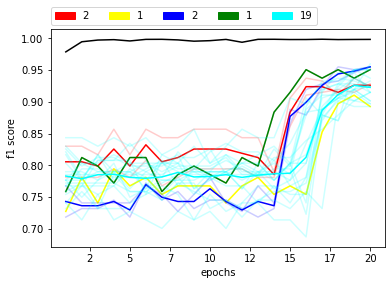

In [70]:
#plotting graphs for loss and accuracies for the top 5 recurrent models:
#plotting val_loss and loss for the models generated and the benchmark model.
from random import randint
import matplotlib.patches as mpatches
color = ['red', 'yellow','blue', 'green','cyan']
leg=[]
for i in range(len(color)):
    leg.append(mpatches.Patch(color=color[i], label=str(len(val_acc[i]))))
n = len(val_acc)
print(n)
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(val_acc[i])):
        plt.plot(x_axis,val_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis, np.mean(val_acc[i], axis=0), color=color[i])
#plt.xlim(-0.5,20.5)
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.plot(x_axis, benchmark_val_acc, color='black')
plt.savefig("fig/Skin_NonSkin_F1_Val_20Epochs_10000.jpeg")

[0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.80249995, 0.8474999, 0.89624995, 0.90874994, 0.9212499]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
0 0
0 1
1 0
2 0
2 1
3 0
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9
4 10
4 11
4 12
4 13
4 14
4 15
4 16
4 17
4 18


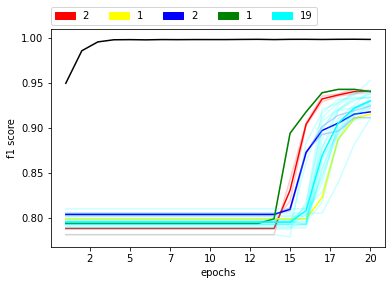

In [71]:
#train accuracy 
from random import randint
color = []
print(train_acc[4][0])
color = ['red', 'yellow','blue', 'green','cyan']
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(train_acc[i])):
        print(i,j)
        plt.plot(x_axis,train_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_acc[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_acc, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Skin_NonSkin_F1_train_20Epochs_10000.jpeg")

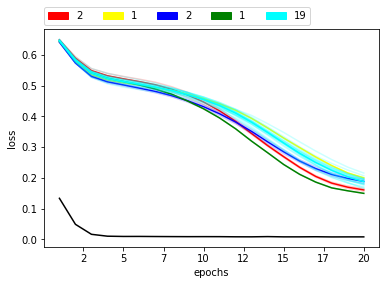

In [72]:
#training loss
from random import randint
color = []
n = len(train_loss)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,train_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Skin_NonSkin_loss_train_20Epochs_10000.jpeg")

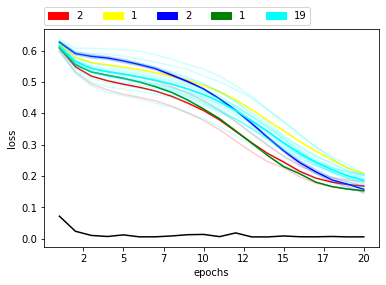

In [73]:
#validation loss loss
from random import randint
color = []
n = len(val_acc)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,val_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(val_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_val_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Skin_NonSkin_loss_val_20Epochs_10000.jpeg")

In [74]:
#lets compute the accuracy for bigger test set 30% benchmark test data
high_test_loss=[]
high_test_f1=[]
for i in range(len(add_weights)):
    for j in range(len(add_weights[i])):
        high_test_model=get_initial_model(X_test.shape[1], 2) #same intial weights
        high_test_model.set_weights(Models[i][0])
        high_test_metrics=high_test_model.evaluate(X_test,y_test)
        if j == 0:
            high_test_loss.append([high_test_metrics[0]])
            high_test_f1.append([high_test_metrics[1]])
        else:
            high_test_loss[i].append(high_test_metrics[0])
            high_test_f1[i].append(high_test_metrics[1])
print(high_test_loss, high_test_f1)

73518/73518 [==============================] - 1s 17us/sample - loss: 0.1835 - accuracy: 0.9311


73518/73518 [==============================] - 1s 18us/sample - loss: 0.1702 - accuracy: 0.9350


73518/73518 [==============================] - 1s 18us/sample - loss: 0.1874 - accuracy: 0.9353


73518/73518 [==============================] - 1s 19us/sample - loss: 0.1585 - accuracy: 0.9351


73518/73518 [==============================] - 2s 22us/sample - loss: 0.1636 - accuracy: 0.9354


73518/73518 [==============================] - 2s 21us/sample - loss: 0.1605 - accuracy: 0.9354


IndexError: list index out of range

In [ ]:
high_test_accs=list(np.array(high_test_f1)[A])
print(high_test_accs)

In [ ]:
#for test accuracy plot
#plot test accuracy of smaller test set
benchmark_test_accs=[benchmark_test_accuracy]*n
ax = plt.gca()
ax.set_ylim([0.7, 1.1])
for i in range(n):
    plt.scatter([i]*len(test_acc[i]),test_acc[i], color=color[i], alpha=0.2)
    plt.scatter(i,high_test_accs[i][0], color=color[i])
plt.plot(benchmark_test_accs, color='black')
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/Skin_NonSkin_test_acc_20Epochs_1000.jpeg")
plt.show()

In [ ]:
#plot for mean model accuracy and benchmark loss:
n=5
ax = plt.gca()
ax.set_ylim([0.7, 0.85])
for i in range(n):
    plt.plot(i, mean_model_acc[i],'o',color=color[i])
    plt.plot(i, mean_model_test_acc[i],'o', mfc='none',color=color[i])
plt.plot([benchmark_acc[-1]]*n,color='black')
plt.plot([benchmark_test_accuracy]*n,'-.',color='black')
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/SkinNonSkin_mean_model_results.jpeg")
plt.show()

In [ ]:
#done for now No need for MNSIT dataset. 

In [20]:
#the below code is for binary classification since MNSIT is a multi-class low-resolution image dataset. I am updating the code in the next cell.
N=1000
#Positive=Pos
#Negative=Neg
positiveN=int((Positive.shape[0]/dataset.shape[0])*N)
negativeN=int(N-positiveN)
print(positiveN, negativeN)
#target variable
#target_variable="default.payment.next.month"
df1=Positive.sample(positiveN)
Positive.drop(df1.index, inplace=True)
df2=Negative.sample(negativeN)
Negative.drop(df2.index, inplace=True)
test_data=df1.append(df2, ignore_index=True)
test_data=test_data.sample(frac = 1) #This is to shuffel the training and testing data
test_data=test_data.sample(frac = 1)
test_data=test_data.sample(frac = 1)
X_test=test_data.drop(columns=[target_variable])
y_test=to_categorical(test_data[target_variable])

# adding dense layer
initial_model= get_initial_model(X_test.shape[1], 2)
initial_model.set_weights(update_weights(initial_model.get_weights()))
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
add_weights=[]
while Positive.empty==False and Negative.empty==False:
  print(positiveN, negativeN)
  df1=Positive.sample(min(positiveN, len(Positive)))
  Positive.drop(df1.index, inplace=True)
  df2=Negative.sample(min(negativeN, len(Negative)))
  Negative.drop(df2.index, inplace=True)
  train_data=df1.append(df2, ignore_index=True)
  train_data=train_data.sample(frac = 1) #shuffel train data 3 times
  train_data=train_data.sample(frac = 1) #shuffel train data 3 times
  train_data=train_data.sample(frac = 1) #shuffel train data 3 times
    
  #all models have different initialization
  # define the sequential model
  """initial_model = keras.Sequential()

    # adding dense layer
  initial_model.add(Dense(5, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
  initial_model.add(Dense(10, activation='relu'))
  initial_model.add(Dense(5, activation='relu'))

    # adding dense layer with softmax activation/output layer
  initial_model.add(Dense(2, activation='softmax'))
  #initial_model.summary()"""
  ann_model=get_initial_model(X_test.shape[1], 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  #train_data[target_variable]=train_data[target_variable]-1 #only for skin_nonskin dataset
  y_train=to_categorical(train_data[target_variable])
  #print(y_train)
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
  print(history.history['f1_m'][-1])
  ann_model.set_weights(update_weights(ann_model.get_weights()))
  pred_test=ann_model.predict(X_test)
  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      add_weights[i].append(ann_model.get_weights())
      val_acc[i].append(history.history['val_f1_m'])
      train_acc[i].append(history.history['f1_m'])
      test_acc[i].append(f1_m(y_test, pred_test))
      val_loss[i].append(history.history['val_loss'])
      train_loss[i].append(history.history['loss'])
      present=True
      break;
  if present==False:
    add_weights.append([ann_model.get_weights()])
    Models.append([ann_model.get_weights(), 1])
    val_acc.append([history.history['val_f1_m']])
    train_acc.append([history.history['f1_m']])
    test_acc.append([f1_m(y_test, pred_test)])
    val_loss.append([history.history['val_loss']])
    train_loss.append([history.history['loss']])
for i in range(len(Models)):
  print(Models[i][1])
print("All Done")

207 793
207 793


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 604us/sample - loss: 0.6729 - f1_m: 0.7950 - val_loss: 0.6501 - val_f1_m: 0.7946
Epoch 2/20
800/800 [==============================] - 0s 58us/sample - loss: 0.6259 - f1_m: 0.7950 - val_loss: 0.6015 - val_f1_m: 0.7946
Epoch 3/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5738 - f1_m: 0.7950 - val_loss: 0.5559 - val_f1_m: 0.7946
Epoch 4/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5336 - f1_m: 0.7950 - val_loss: 0.5323 - val_f1_m: 0.7946
Epoch 5/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5171 - f1_m: 0.7950 - val_loss: 0.5239 - val_f1_m: 0.7679
Epoch 6/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5089 - f1_m: 0.7950 - val_loss: 0.5174 - val_f1_m: 0.7946
Epoch 7/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5031 - f1_m: 0.7950 - val_loss: 0.5106 - val_f1_m: 0

Epoch 5/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5177 - f1_m: 0.7925 - val_loss: 0.5061 - val_f1_m: 0.8036
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5084 - f1_m: 0.7925 - val_loss: 0.4985 - val_f1_m: 0.7902
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5005 - f1_m: 0.7925 - val_loss: 0.4889 - val_f1_m: 0.7768
Epoch 8/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4903 - f1_m: 0.7925 - val_loss: 0.4788 - val_f1_m: 0.8170
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4797 - f1_m: 0.7925 - val_loss: 0.4662 - val_f1_m: 0.7902
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4648 - f1_m: 0.7925 - val_loss: 0.4503 - val_f1_m: 0.8170
Epoch 11/20
800/800 [==============================] - 0s 54us/sample - loss: 0.4474 - f1_m: 0.7925 - val_loss: 0.4289 - val_f1_m: 0.8036
Epoch 12/20
800/800 [==================

Epoch 9/20
800/800 [==============================] - 0s 61us/sample - loss: 0.4874 - f1_m: 0.7862 - val_loss: 0.4392 - val_f1_m: 0.8393
Epoch 10/20
800/800 [==============================] - 0s 62us/sample - loss: 0.4737 - f1_m: 0.7862 - val_loss: 0.4260 - val_f1_m: 0.8393
Epoch 11/20
800/800 [==============================] - 0s 64us/sample - loss: 0.4566 - f1_m: 0.7862 - val_loss: 0.4072 - val_f1_m: 0.7857
Epoch 12/20
800/800 [==============================] - 0s 67us/sample - loss: 0.4357 - f1_m: 0.7862 - val_loss: 0.3863 - val_f1_m: 0.8125
Epoch 13/20
800/800 [==============================] - 0s 77us/sample - loss: 0.4096 - f1_m: 0.7862 - val_loss: 0.3611 - val_f1_m: 0.7857
Epoch 14/20
800/800 [==============================] - 0s 123us/sample - loss: 0.3787 - f1_m: 0.7862 - val_loss: 0.3291 - val_f1_m: 0.8125
Epoch 15/20
800/800 [==============================] - 0s 92us/sample - loss: 0.3400 - f1_m: 0.7862 - val_loss: 0.2957 - val_f1_m: 0.8393
Epoch 16/20
800/800 [=============

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 693us/sample - loss: 0.6798 - f1_m: 0.7925 - val_loss: 0.6642 - val_f1_m: 0.7902
Epoch 2/20
800/800 [==============================] - 0s 79us/sample - loss: 0.6487 - f1_m: 0.7925 - val_loss: 0.6290 - val_f1_m: 0.8170
Epoch 3/20
800/800 [==============================] - 0s 106us/sample - loss: 0.6105 - f1_m: 0.7925 - val_loss: 0.5854 - val_f1_m: 0.8036
Epoch 4/20
800/800 [==============================] - 0s 67us/sample - loss: 0.5678 - f1_m: 0.7925 - val_loss: 0.5486 - val_f1_m: 0.7768
Epoch 5/20
800/800 [==============================] - 0s 76us/sample - loss: 0.5387 - f1_m: 0.7925 - val_loss: 0.5257 - val_f1_m: 0.7768
Epoch 6/20
800/800 [==============================] - 0s 63us/sample - loss: 0.5211 - f1_m: 0.7925 - val_loss: 0.5150 - val_f1_m: 0.8036
Epoch 7/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5119 - f1_m: 0.7925 - val_loss: 0.5059 - val_f1_m: 

800/800 [==============================] - 0s 62us/sample - loss: 0.5423 - f1_m: 0.7837 - val_loss: 0.4844 - val_f1_m: 0.8214
Epoch 5/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5273 - f1_m: 0.7837 - val_loss: 0.4666 - val_f1_m: 0.8482
Epoch 6/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5190 - f1_m: 0.7837 - val_loss: 0.4585 - val_f1_m: 0.8482
Epoch 7/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5107 - f1_m: 0.7837 - val_loss: 0.4480 - val_f1_m: 0.8214
Epoch 8/20
800/800 [==============================] - 0s 58us/sample - loss: 0.5006 - f1_m: 0.7837 - val_loss: 0.4383 - val_f1_m: 0.8482
Epoch 9/20
800/800 [==============================] - 0s 60us/sample - loss: 0.4874 - f1_m: 0.7837 - val_loss: 0.4228 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4737 - f1_m: 0.7837 - val_loss: 0.4073 - val_f1_m: 0.8482
Epoch 11/20
800/800 [==============================

Epoch 8/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4904 - f1_m: 0.7962 - val_loss: 0.5074 - val_f1_m: 0.7634
Epoch 9/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4807 - f1_m: 0.7962 - val_loss: 0.4964 - val_f1_m: 0.7634
Epoch 10/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4683 - f1_m: 0.7962 - val_loss: 0.4837 - val_f1_m: 0.8036
Epoch 11/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4544 - f1_m: 0.7962 - val_loss: 0.4684 - val_f1_m: 0.7902
Epoch 12/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4385 - f1_m: 0.7962 - val_loss: 0.4498 - val_f1_m: 0.7500
Epoch 13/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4166 - f1_m: 0.7962 - val_loss: 0.4262 - val_f1_m: 0.7634
Epoch 14/20
800/800 [==============================] - 0s 51us/sample - loss: 0.3916 - f1_m: 0.7962 - val_loss: 0.3992 - val_f1_m: 0.7634
Epoch 15/20
800/800 [===============

if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 623us/sample - loss: 0.6788 - f1_m: 0.7942 - val_loss: 0.6649 - val_f1_m: 0.7812
Epoch 2/20
800/800 [==============================] - 0s 60us/sample - loss: 0.6477 - f1_m: 0.7950 - val_loss: 0.6321 - val_f1_m: 0.7946
Epoch 3/20
800/800 [==============================] - 0s 59us/sample - loss: 0.6084 - f1_m: 0.7950 - val_loss: 0.5940 - val_f1_m: 0.8080
Epoch 4/20
800/800 [==============================] - 0s 62us/sample - loss: 0.5660 - f1_m: 0.7950 - val_loss: 0.5594 - val_f1_m: 0.7812
Epoch 5/20
800/800 [==============================] - 0s 61us/sample - loss: 0.5342 - f1_m: 0.7950 - val_loss: 0.5400 - val_f1_m: 0.8080
Epoch 6/20
800/800 [==============================] - 0s 59us/sample - loss: 0.5182 - f1_m: 0.7950 - val_loss: 0.5329 - val_f1_m: 0.7946
Epoch 7/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5117 - f1_m: 0.7950 - val_loss: 0.527

Epoch 13/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4839 - f1_m: 0.7850 - val_loss: 0.4298 - val_f1_m: 0.8304
Epoch 14/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4707 - f1_m: 0.7850 - val_loss: 0.4173 - val_f1_m: 0.8036
Epoch 15/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4549 - f1_m: 0.7850 - val_loss: 0.4015 - val_f1_m: 0.8170
Epoch 16/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4361 - f1_m: 0.7850 - val_loss: 0.3819 - val_f1_m: 0.8036
Epoch 17/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4143 - f1_m: 0.7850 - val_loss: 0.3601 - val_f1_m: 0.8304
Epoch 18/20
800/800 [==============================] - 0s 50us/sample - loss: 0.3874 - f1_m: 0.7850 - val_loss: 0.3270 - val_f1_m: 0.8304
Epoch 19/20
800/800 [==============================] - 0s 50us/sample - loss: 0.3500 - f1_m: 0.7850 - val_loss: 0.2912 - val_f1_m: 0.8170
Epoch 20/20
800/800 [=============

800/800 [==============================] - 0s 49us/sample - loss: 0.4310 - f1_m: 0.7875 - val_loss: 0.3944 - val_f1_m: 0.8080
Epoch 17/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4104 - f1_m: 0.7875 - val_loss: 0.3726 - val_f1_m: 0.8080
Epoch 18/20
800/800 [==============================] - 0s 51us/sample - loss: 0.3862 - f1_m: 0.7875 - val_loss: 0.3452 - val_f1_m: 0.8214
Epoch 19/20
800/800 [==============================] - 0s 50us/sample - loss: 0.3506 - f1_m: 0.7875 - val_loss: 0.3105 - val_f1_m: 0.8080
Epoch 20/20
800/800 [==============================] - 0s 49us/sample - loss: 0.3131 - f1_m: 0.7875 - val_loss: 0.2804 - val_f1_m: 0.8080
0.7874999
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 575us/sample - loss: 0.6733 - f1_m: 0.7850 - val_loss: 0.6436 - val_f1_m: 0.8304
Epoch 2/20
800/800 [==============================] - 0s 52us/sample - loss: 0.6269 - f1_m: 0.7850 - val_loss: 0.

800/800 [==============================] - 0s 46us/sample - loss: 0.2470 - f1_m: 0.8012 - val_loss: 0.2682 - val_f1_m: 0.7589
Epoch 20/20
800/800 [==============================] - 0s 45us/sample - loss: 0.2297 - f1_m: 0.8012 - val_loss: 0.2555 - val_f1_m: 0.7723
0.8012499
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 574us/sample - loss: 0.6783 - f1_m: 0.8055 - val_loss: 0.6692 - val_f1_m: 0.7545
Epoch 2/20
800/800 [==============================] - 0s 50us/sample - loss: 0.6443 - f1_m: 0.8062 - val_loss: 0.6406 - val_f1_m: 0.7411
Epoch 3/20
800/800 [==============================] - 0s 50us/sample - loss: 0.6004 - f1_m: 0.8062 - val_loss: 0.6090 - val_f1_m: 0.7143
Epoch 4/20
800/800 [==============================] - 0s 49us/sample - loss: 0.5541 - f1_m: 0.8062 - val_loss: 0.5881 - val_f1_m: 0.7679
Epoch 5/20
800/800 [==============================] - 0s 49us/sample - loss: 0.5211 - f1_m: 0.8062 - val_loss: 0.585

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 575us/sample - loss: 0.6726 - f1_m: 0.7987 - val_loss: 0.6544 - val_f1_m: 0.7812
Epoch 2/20
800/800 [==============================] - 0s 52us/sample - loss: 0.6269 - f1_m: 0.7987 - val_loss: 0.6101 - val_f1_m: 0.7812
Epoch 3/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5737 - f1_m: 0.7987 - val_loss: 0.5701 - val_f1_m: 0.7812
Epoch 4/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5333 - f1_m: 0.7987 - val_loss: 0.5491 - val_f1_m: 0.7812
Epoch 5/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5133 - f1_m: 0.7987 - val_loss: 0.5431 - val_f1_m: 0.7411
Epoch 6/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5046 - f1_m: 0.7987 - val_loss: 0.5378 - val_f1_m: 0.7679
Epoch 7/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4978 - f1_m: 0.7987 - val_loss: 0.5300 - val_f1_m: 0

800/800 [==============================] - 0s 54us/sample - loss: 0.5448 - f1_m: 0.7825 - val_loss: 0.4815 - val_f1_m: 0.8393
Epoch 5/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5297 - f1_m: 0.7825 - val_loss: 0.4655 - val_f1_m: 0.8393
Epoch 6/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5221 - f1_m: 0.7825 - val_loss: 0.4566 - val_f1_m: 0.8527
Epoch 7/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5149 - f1_m: 0.7825 - val_loss: 0.4487 - val_f1_m: 0.8259
Epoch 8/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5058 - f1_m: 0.7825 - val_loss: 0.4399 - val_f1_m: 0.8393
Epoch 9/20
800/800 [==============================] - 0s 49us/sample - loss: 0.4945 - f1_m: 0.7825 - val_loss: 0.4287 - val_f1_m: 0.8125
Epoch 10/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4826 - f1_m: 0.7825 - val_loss: 0.4142 - val_f1_m: 0.8393
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 51us/sample - loss: 0.5104 - f1_m: 0.7862 - val_loss: 0.4615 - val_f1_m: 0.8125
Epoch 8/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5001 - f1_m: 0.7862 - val_loss: 0.4536 - val_f1_m: 0.8259
Epoch 9/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4896 - f1_m: 0.7862 - val_loss: 0.4408 - val_f1_m: 0.7991
Epoch 10/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4762 - f1_m: 0.7862 - val_loss: 0.4240 - val_f1_m: 0.8393
Epoch 11/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4590 - f1_m: 0.7862 - val_loss: 0.4056 - val_f1_m: 0.7991
Epoch 12/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4367 - f1_m: 0.7862 - val_loss: 0.3802 - val_f1_m: 0.8125
Epoch 13/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4106 - f1_m: 0.7862 - val_loss: 0.3552 - val_f1_m: 0.8259
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 60us/sample - loss: 0.4746 - f1_m: 0.7962 - val_loss: 0.4907 - val_f1_m: 0.7634
Epoch 11/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4626 - f1_m: 0.7962 - val_loss: 0.4780 - val_f1_m: 0.7634
Epoch 12/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4485 - f1_m: 0.7962 - val_loss: 0.4622 - val_f1_m: 0.7902
Epoch 13/20
800/800 [==============================] - 0s 54us/sample - loss: 0.4311 - f1_m: 0.7962 - val_loss: 0.4425 - val_f1_m: 0.7902
Epoch 14/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4090 - f1_m: 0.7962 - val_loss: 0.4187 - val_f1_m: 0.7902
Epoch 15/20
800/800 [==============================] - 0s 56us/sample - loss: 0.3844 - f1_m: 0.7962 - val_loss: 0.3904 - val_f1_m: 0.7902
Epoch 16/20
800/800 [==============================] - 0s 58us/sample - loss: 0.3546 - f1_m: 0.7962 - val_loss: 0.3583 - val_f1_m: 0.7768
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 579us/sample - loss: 0.6777 - f1_m: 0.8030 - val_loss: 0.6681 - val_f1_m: 0.7634
Epoch 2/20
800/800 [==============================] - 0s 56us/sample - loss: 0.6450 - f1_m: 0.8037 - val_loss: 0.6394 - val_f1_m: 0.7232
Epoch 3/20
800/800 [==============================] - 0s 56us/sample - loss: 0.6039 - f1_m: 0.8037 - val_loss: 0.6064 - val_f1_m: 0.7634
Epoch 4/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5579 - f1_m: 0.8037 - val_loss: 0.5808 - val_f1_m: 0.7500
Epoch 5/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5250 - f1_m: 0.8037 - val_loss: 0.5727 - val_f1_m: 0.7232
Epoch 6/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5072 - f1_m: 0.8037 - val_loss: 0.5706 - val_f1_m: 0.7366
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5010 - f1_m: 0.8037 - val_loss: 0.5704 - val_f1_m: 0

800/800 [==============================] - 0s 56us/sample - loss: 0.5772 - f1_m: 0.7862 - val_loss: 0.5300 - val_f1_m: 0.7991
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5448 - f1_m: 0.7862 - val_loss: 0.4996 - val_f1_m: 0.7991
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5297 - f1_m: 0.7862 - val_loss: 0.4814 - val_f1_m: 0.7991
Epoch 7/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5215 - f1_m: 0.7862 - val_loss: 0.4748 - val_f1_m: 0.8259
Epoch 8/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5156 - f1_m: 0.7862 - val_loss: 0.4682 - val_f1_m: 0.8393
Epoch 9/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5100 - f1_m: 0.7862 - val_loss: 0.4629 - val_f1_m: 0.7991
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5038 - f1_m: 0.7862 - val_loss: 0.4557 - val_f1_m: 0.8125
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 52us/sample - loss: 0.5102 - f1_m: 0.7950 - val_loss: 0.5142 - val_f1_m: 0.7679
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5051 - f1_m: 0.7950 - val_loss: 0.5097 - val_f1_m: 0.7679
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4999 - f1_m: 0.7950 - val_loss: 0.5053 - val_f1_m: 0.7812
Epoch 10/20
800/800 [==============================] - 0s 54us/sample - loss: 0.4948 - f1_m: 0.7950 - val_loss: 0.5004 - val_f1_m: 0.7946
Epoch 11/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4888 - f1_m: 0.7950 - val_loss: 0.4951 - val_f1_m: 0.7679
Epoch 12/20
800/800 [==============================] - 0s 54us/sample - loss: 0.4824 - f1_m: 0.7950 - val_loss: 0.4889 - val_f1_m: 0.7946
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4742 - f1_m: 0.7950 - val_loss: 0.4799 - val_f1_m: 0.7812
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 52us/sample - loss: 0.4669 - f1_m: 0.7925 - val_loss: 0.4563 - val_f1_m: 0.8036
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4506 - f1_m: 0.7925 - val_loss: 0.4393 - val_f1_m: 0.7902
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4300 - f1_m: 0.7925 - val_loss: 0.4180 - val_f1_m: 0.7902
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4059 - f1_m: 0.7925 - val_loss: 0.3916 - val_f1_m: 0.8036
Epoch 14/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3754 - f1_m: 0.7925 - val_loss: 0.3596 - val_f1_m: 0.8036
Epoch 15/20
800/800 [==============================] - 0s 53us/sample - loss: 0.3408 - f1_m: 0.7925 - val_loss: 0.3230 - val_f1_m: 0.7902
Epoch 16/20
800/800 [==============================] - 0s 50us/sample - loss: 0.3000 - f1_m: 0.7925 - val_loss: 0.2806 - val_f1_m: 0.8036
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 605us/sample - loss: 0.6727 - f1_m: 0.7825 - val_loss: 0.6410 - val_f1_m: 0.8393
Epoch 2/20
800/800 [==============================] - 0s 58us/sample - loss: 0.6273 - f1_m: 0.7825 - val_loss: 0.5796 - val_f1_m: 0.8393
Epoch 3/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5793 - f1_m: 0.7825 - val_loss: 0.5177 - val_f1_m: 0.8527
Epoch 4/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5448 - f1_m: 0.7825 - val_loss: 0.4762 - val_f1_m: 0.8259
Epoch 5/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5321 - f1_m: 0.7825 - val_loss: 0.4601 - val_f1_m: 0.8125
Epoch 6/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5243 - f1_m: 0.7825 - val_loss: 0.4538 - val_f1_m: 0.8527
Epoch 7/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5176 - f1_m: 0.7825 - val_loss: 0.4457 - val_f1_m: 0

800/800 [==============================] - 0s 57us/sample - loss: 0.5359 - f1_m: 0.7912 - val_loss: 0.5136 - val_f1_m: 0.8080
Epoch 5/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5196 - f1_m: 0.7912 - val_loss: 0.5025 - val_f1_m: 0.8080
Epoch 6/20
800/800 [==============================] - 0s 58us/sample - loss: 0.5102 - f1_m: 0.7912 - val_loss: 0.4959 - val_f1_m: 0.7946
Epoch 7/20
800/800 [==============================] - 0s 60us/sample - loss: 0.5027 - f1_m: 0.7912 - val_loss: 0.4882 - val_f1_m: 0.7946
Epoch 8/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4933 - f1_m: 0.7912 - val_loss: 0.4785 - val_f1_m: 0.8080
Epoch 9/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4818 - f1_m: 0.7912 - val_loss: 0.4667 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4683 - f1_m: 0.7912 - val_loss: 0.4533 - val_f1_m: 0.8080
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 55us/sample - loss: 0.5122 - f1_m: 0.7875 - val_loss: 0.4756 - val_f1_m: 0.7946
Epoch 8/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5044 - f1_m: 0.7875 - val_loss: 0.4667 - val_f1_m: 0.8080
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4948 - f1_m: 0.7875 - val_loss: 0.4561 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4811 - f1_m: 0.7875 - val_loss: 0.4423 - val_f1_m: 0.8348
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4674 - f1_m: 0.7875 - val_loss: 0.4278 - val_f1_m: 0.8348
Epoch 12/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4502 - f1_m: 0.7875 - val_loss: 0.4088 - val_f1_m: 0.8348
Epoch 13/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4290 - f1_m: 0.7875 - val_loss: 0.3873 - val_f1_m: 0.7946
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 54us/sample - loss: 0.4784 - f1_m: 0.7862 - val_loss: 0.4304 - val_f1_m: 0.7991
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4650 - f1_m: 0.7862 - val_loss: 0.4153 - val_f1_m: 0.7857
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4490 - f1_m: 0.7862 - val_loss: 0.3959 - val_f1_m: 0.8393
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4275 - f1_m: 0.7862 - val_loss: 0.3722 - val_f1_m: 0.8125
Epoch 14/20
800/800 [==============================] - 0s 53us/sample - loss: 0.3995 - f1_m: 0.7862 - val_loss: 0.3426 - val_f1_m: 0.8125
Epoch 15/20
800/800 [==============================] - 0s 53us/sample - loss: 0.3707 - f1_m: 0.7862 - val_loss: 0.3124 - val_f1_m: 0.8393
Epoch 16/20
800/800 [==============================] - 0s 55us/sample - loss: 0.3433 - f1_m: 0.7862 - val_loss: 0.2836 - val_f1_m: 0.7991
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 586us/sample - loss: 0.6738 - f1_m: 0.7875 - val_loss: 0.6468 - val_f1_m: 0.8214
Epoch 2/20
800/800 [==============================] - 0s 55us/sample - loss: 0.6285 - f1_m: 0.7875 - val_loss: 0.5905 - val_f1_m: 0.8214
Epoch 3/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5787 - f1_m: 0.7875 - val_loss: 0.5346 - val_f1_m: 0.8348
Epoch 4/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5410 - f1_m: 0.7875 - val_loss: 0.5009 - val_f1_m: 0.8214
Epoch 5/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5267 - f1_m: 0.7875 - val_loss: 0.4860 - val_f1_m: 0.8080
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5195 - f1_m: 0.7875 - val_loss: 0.4804 - val_f1_m: 0.8214
Epoch 7/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5126 - f1_m: 0.7875 - val_loss: 0.4723 - val_f1_m: 0

800/800 [==============================] - 0s 56us/sample - loss: 0.5339 - f1_m: 0.7950 - val_loss: 0.5359 - val_f1_m: 0.7679
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5165 - f1_m: 0.7950 - val_loss: 0.5281 - val_f1_m: 0.7679
Epoch 6/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5102 - f1_m: 0.7950 - val_loss: 0.5215 - val_f1_m: 0.7812
Epoch 7/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5043 - f1_m: 0.7950 - val_loss: 0.5155 - val_f1_m: 0.7946
Epoch 8/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4976 - f1_m: 0.7950 - val_loss: 0.5075 - val_f1_m: 0.7679
Epoch 9/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4899 - f1_m: 0.7950 - val_loss: 0.4968 - val_f1_m: 0.7812
Epoch 10/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4794 - f1_m: 0.7950 - val_loss: 0.4844 - val_f1_m: 0.7946
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 57us/sample - loss: 0.5156 - f1_m: 0.7850 - val_loss: 0.4600 - val_f1_m: 0.8170
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5075 - f1_m: 0.7850 - val_loss: 0.4534 - val_f1_m: 0.8304
Epoch 9/20
800/800 [==============================] - 0s 54us/sample - loss: 0.4970 - f1_m: 0.7850 - val_loss: 0.4405 - val_f1_m: 0.8304
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4830 - f1_m: 0.7850 - val_loss: 0.4287 - val_f1_m: 0.8304
Epoch 11/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4680 - f1_m: 0.7850 - val_loss: 0.4114 - val_f1_m: 0.8170
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4501 - f1_m: 0.7850 - val_loss: 0.3926 - val_f1_m: 0.8170
Epoch 13/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4252 - f1_m: 0.7850 - val_loss: 0.3677 - val_f1_m: 0.8170
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 53us/sample - loss: 0.4489 - f1_m: 0.7912 - val_loss: 0.4320 - val_f1_m: 0.8214
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4234 - f1_m: 0.7912 - val_loss: 0.4073 - val_f1_m: 0.7946
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3938 - f1_m: 0.7912 - val_loss: 0.3783 - val_f1_m: 0.8080
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3601 - f1_m: 0.7912 - val_loss: 0.3461 - val_f1_m: 0.7679
Epoch 14/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3270 - f1_m: 0.7912 - val_loss: 0.3176 - val_f1_m: 0.7812
Epoch 15/20
800/800 [==============================] - 0s 53us/sample - loss: 0.2995 - f1_m: 0.7912 - val_loss: 0.2947 - val_f1_m: 0.7812
Epoch 16/20
800/800 [==============================] - 0s 51us/sample - loss: 0.2767 - f1_m: 0.7912 - val_loss: 0.2745 - val_f1_m: 0.7946
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 590us/sample - loss: 0.6785 - f1_m: 0.7896 - val_loss: 0.6625 - val_f1_m: 0.7946
Epoch 2/20
800/800 [==============================] - 0s 57us/sample - loss: 0.6482 - f1_m: 0.7912 - val_loss: 0.6265 - val_f1_m: 0.8080
Epoch 3/20
800/800 [==============================] - 0s 57us/sample - loss: 0.6095 - f1_m: 0.7912 - val_loss: 0.5827 - val_f1_m: 0.8080
Epoch 4/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5679 - f1_m: 0.7912 - val_loss: 0.5417 - val_f1_m: 0.8214
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5378 - f1_m: 0.7912 - val_loss: 0.5180 - val_f1_m: 0.8080
Epoch 6/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5234 - f1_m: 0.7912 - val_loss: 0.5081 - val_f1_m: 0.7946
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5164 - f1_m: 0.7912 - val_loss: 0.5017 - val_f1_m: 0

800/800 [==============================] - 0s 55us/sample - loss: 0.5677 - f1_m: 0.7925 - val_loss: 0.5418 - val_f1_m: 0.7902
Epoch 5/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5389 - f1_m: 0.7925 - val_loss: 0.5185 - val_f1_m: 0.8036
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5251 - f1_m: 0.7925 - val_loss: 0.5099 - val_f1_m: 0.7902
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5187 - f1_m: 0.7925 - val_loss: 0.5038 - val_f1_m: 0.7634
Epoch 8/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5134 - f1_m: 0.7925 - val_loss: 0.4993 - val_f1_m: 0.7902
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5079 - f1_m: 0.7925 - val_loss: 0.4945 - val_f1_m: 0.8036
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5025 - f1_m: 0.7925 - val_loss: 0.4901 - val_f1_m: 0.7902
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 57us/sample - loss: 0.5010 - f1_m: 0.7962 - val_loss: 0.5161 - val_f1_m: 0.7634
Epoch 8/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4942 - f1_m: 0.7962 - val_loss: 0.5089 - val_f1_m: 0.7902
Epoch 9/20
800/800 [==============================] - 0s 57us/sample - loss: 0.4856 - f1_m: 0.7962 - val_loss: 0.4980 - val_f1_m: 0.7768
Epoch 10/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4725 - f1_m: 0.7962 - val_loss: 0.4834 - val_f1_m: 0.7902
Epoch 11/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4580 - f1_m: 0.7962 - val_loss: 0.4682 - val_f1_m: 0.7902
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4423 - f1_m: 0.7962 - val_loss: 0.4491 - val_f1_m: 0.7902
Epoch 13/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4207 - f1_m: 0.7962 - val_loss: 0.4247 - val_f1_m: 0.7902
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 53us/sample - loss: 0.4981 - f1_m: 0.7887 - val_loss: 0.4762 - val_f1_m: 0.8170
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4913 - f1_m: 0.7887 - val_loss: 0.4686 - val_f1_m: 0.8170
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4834 - f1_m: 0.7887 - val_loss: 0.4614 - val_f1_m: 0.8170
Epoch 13/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4742 - f1_m: 0.7887 - val_loss: 0.4509 - val_f1_m: 0.8036
Epoch 14/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4629 - f1_m: 0.7887 - val_loss: 0.4388 - val_f1_m: 0.7902
Epoch 15/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4488 - f1_m: 0.7887 - val_loss: 0.4230 - val_f1_m: 0.8036
Epoch 16/20
800/800 [==============================] - 0s 50us/sample - loss: 0.4315 - f1_m: 0.7887 - val_loss: 0.4050 - val_f1_m: 0.8170
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 586us/sample - loss: 0.6792 - f1_m: 0.7925 - val_loss: 0.6634 - val_f1_m: 0.7902
Epoch 2/20
800/800 [==============================] - 0s 55us/sample - loss: 0.6417 - f1_m: 0.7925 - val_loss: 0.6104 - val_f1_m: 0.7902
Epoch 3/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5850 - f1_m: 0.7925 - val_loss: 0.5571 - val_f1_m: 0.8036
Epoch 4/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5430 - f1_m: 0.7925 - val_loss: 0.5265 - val_f1_m: 0.7768
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5223 - f1_m: 0.7925 - val_loss: 0.5134 - val_f1_m: 0.8036
Epoch 6/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5120 - f1_m: 0.7925 - val_loss: 0.5053 - val_f1_m: 0.7634
Epoch 7/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5022 - f1_m: 0.7925 - val_loss: 0.4961 - val_f1_m: 0

800/800 [==============================] - 0s 56us/sample - loss: 0.5325 - f1_m: 0.7987 - val_loss: 0.5530 - val_f1_m: 0.7812
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5150 - f1_m: 0.7987 - val_loss: 0.5480 - val_f1_m: 0.7812
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5053 - f1_m: 0.7987 - val_loss: 0.5406 - val_f1_m: 0.7679
Epoch 7/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4990 - f1_m: 0.7987 - val_loss: 0.5340 - val_f1_m: 0.7812
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4901 - f1_m: 0.7987 - val_loss: 0.5183 - val_f1_m: 0.7679
Epoch 9/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4775 - f1_m: 0.7987 - val_loss: 0.5060 - val_f1_m: 0.7812
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4641 - f1_m: 0.7987 - val_loss: 0.4909 - val_f1_m: 0.7812
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 52us/sample - loss: 0.5059 - f1_m: 0.7875 - val_loss: 0.4635 - val_f1_m: 0.8080
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4905 - f1_m: 0.7875 - val_loss: 0.4528 - val_f1_m: 0.8348
Epoch 9/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4756 - f1_m: 0.7875 - val_loss: 0.4370 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4559 - f1_m: 0.7875 - val_loss: 0.4209 - val_f1_m: 0.8348
Epoch 11/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4311 - f1_m: 0.7875 - val_loss: 0.3949 - val_f1_m: 0.7946
Epoch 12/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4016 - f1_m: 0.7875 - val_loss: 0.3678 - val_f1_m: 0.8214
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3687 - f1_m: 0.7875 - val_loss: 0.3368 - val_f1_m: 0.8214
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 52us/sample - loss: 0.4878 - f1_m: 0.7887 - val_loss: 0.4491 - val_f1_m: 0.8036
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4758 - f1_m: 0.7887 - val_loss: 0.4351 - val_f1_m: 0.8036
Epoch 12/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4595 - f1_m: 0.7887 - val_loss: 0.4194 - val_f1_m: 0.7902
Epoch 13/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4419 - f1_m: 0.7887 - val_loss: 0.3997 - val_f1_m: 0.8036
Epoch 14/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4201 - f1_m: 0.7887 - val_loss: 0.3799 - val_f1_m: 0.8170
Epoch 15/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3944 - f1_m: 0.7887 - val_loss: 0.3465 - val_f1_m: 0.8304
Epoch 16/20
800/800 [==============================] - 0s 51us/sample - loss: 0.3597 - f1_m: 0.7887 - val_loss: 0.3153 - val_f1_m: 0.8036
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 2s 2ms/sample - loss: 0.6721 - f1_m: 0.8005 - val_loss: 0.6540 - val_f1_m: 0.7321
Epoch 2/20
800/800 [==============================] - 0s 56us/sample - loss: 0.6215 - f1_m: 0.8012 - val_loss: 0.6111 - val_f1_m: 0.7187
Epoch 3/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5690 - f1_m: 0.8012 - val_loss: 0.5744 - val_f1_m: 0.7455
Epoch 4/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5265 - f1_m: 0.8012 - val_loss: 0.5614 - val_f1_m: 0.7857
Epoch 5/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5086 - f1_m: 0.8012 - val_loss: 0.5577 - val_f1_m: 0.7589
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5013 - f1_m: 0.8012 - val_loss: 0.5547 - val_f1_m: 0.7857
Epoch 7/20
800/800 [==============================] - 0s 56us/sample - loss: 0.4956 - f1_m: 0.8012 - val_loss: 0.5493 - val_f1_m: 0.7

800/800 [==============================] - 0s 56us/sample - loss: 0.5723 - f1_m: 0.7875 - val_loss: 0.5319 - val_f1_m: 0.8348
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5440 - f1_m: 0.7875 - val_loss: 0.5037 - val_f1_m: 0.8348
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5303 - f1_m: 0.7875 - val_loss: 0.4920 - val_f1_m: 0.8080
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5227 - f1_m: 0.7875 - val_loss: 0.4843 - val_f1_m: 0.8214
Epoch 8/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5166 - f1_m: 0.7875 - val_loss: 0.4775 - val_f1_m: 0.7812
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5104 - f1_m: 0.7875 - val_loss: 0.4712 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5039 - f1_m: 0.7875 - val_loss: 0.4646 - val_f1_m: 0.8214
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 53us/sample - loss: 0.5170 - f1_m: 0.7912 - val_loss: 0.5039 - val_f1_m: 0.7946
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5112 - f1_m: 0.7912 - val_loss: 0.4985 - val_f1_m: 0.7946
Epoch 9/20
800/800 [==============================] - 0s 51us/sample - loss: 0.5069 - f1_m: 0.7912 - val_loss: 0.4926 - val_f1_m: 0.7946
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4996 - f1_m: 0.7912 - val_loss: 0.4875 - val_f1_m: 0.7946
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4939 - f1_m: 0.7912 - val_loss: 0.4808 - val_f1_m: 0.7946
Epoch 12/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4862 - f1_m: 0.7912 - val_loss: 0.4730 - val_f1_m: 0.8214
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4761 - f1_m: 0.7912 - val_loss: 0.4625 - val_f1_m: 0.7812
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 52us/sample - loss: 0.4558 - f1_m: 0.7975 - val_loss: 0.4787 - val_f1_m: 0.7589
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4359 - f1_m: 0.7975 - val_loss: 0.4534 - val_f1_m: 0.7321
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4118 - f1_m: 0.7975 - val_loss: 0.4256 - val_f1_m: 0.7723
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3843 - f1_m: 0.7975 - val_loss: 0.3928 - val_f1_m: 0.7723
Epoch 14/20
800/800 [==============================] - 0s 51us/sample - loss: 0.3519 - f1_m: 0.7975 - val_loss: 0.3570 - val_f1_m: 0.7723
Epoch 15/20
800/800 [==============================] - 0s 51us/sample - loss: 0.3203 - f1_m: 0.7975 - val_loss: 0.3293 - val_f1_m: 0.7857
Epoch 16/20
800/800 [==============================] - 0s 51us/sample - loss: 0.2940 - f1_m: 0.7975 - val_loss: 0.3070 - val_f1_m: 0.7857
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 591us/sample - loss: 0.6782 - f1_m: 0.7992 - val_loss: 0.6666 - val_f1_m: 0.7768
Epoch 2/20
800/800 [==============================] - 0s 57us/sample - loss: 0.6470 - f1_m: 0.8000 - val_loss: 0.6369 - val_f1_m: 0.7500
Epoch 3/20
800/800 [==============================] - 0s 53us/sample - loss: 0.6092 - f1_m: 0.8000 - val_loss: 0.6013 - val_f1_m: 0.7768
Epoch 4/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5659 - f1_m: 0.8000 - val_loss: 0.5696 - val_f1_m: 0.7634
Epoch 5/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5315 - f1_m: 0.8000 - val_loss: 0.5530 - val_f1_m: 0.7500
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5138 - f1_m: 0.8000 - val_loss: 0.5477 - val_f1_m: 0.7902
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5076 - f1_m: 0.8000 - val_loss: 0.5445 - val_f1_m: 0

800/800 [==============================] - 0s 57us/sample - loss: 0.5652 - f1_m: 0.8000 - val_loss: 0.5712 - val_f1_m: 0.7634
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5324 - f1_m: 0.8000 - val_loss: 0.5572 - val_f1_m: 0.7902
Epoch 6/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5155 - f1_m: 0.8000 - val_loss: 0.5529 - val_f1_m: 0.7366
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5073 - f1_m: 0.8000 - val_loss: 0.5480 - val_f1_m: 0.7634
Epoch 8/20
800/800 [==============================] - 0s 52us/sample - loss: 0.5009 - f1_m: 0.8000 - val_loss: 0.5425 - val_f1_m: 0.7500
Epoch 9/20
800/800 [==============================] - 0s 51us/sample - loss: 0.4954 - f1_m: 0.8000 - val_loss: 0.5385 - val_f1_m: 0.7500
Epoch 10/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4896 - f1_m: 0.8000 - val_loss: 0.5313 - val_f1_m: 0.7634
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 52us/sample - loss: 0.5083 - f1_m: 0.7875 - val_loss: 0.4729 - val_f1_m: 0.8080
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4993 - f1_m: 0.7875 - val_loss: 0.4639 - val_f1_m: 0.8080
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4897 - f1_m: 0.7875 - val_loss: 0.4528 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4795 - f1_m: 0.7875 - val_loss: 0.4414 - val_f1_m: 0.8080
Epoch 11/20
800/800 [==============================] - 0s 54us/sample - loss: 0.4655 - f1_m: 0.7875 - val_loss: 0.4271 - val_f1_m: 0.8214
Epoch 12/20
800/800 [==============================] - 0s 54us/sample - loss: 0.4475 - f1_m: 0.7875 - val_loss: 0.4073 - val_f1_m: 0.8348
Epoch 13/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4234 - f1_m: 0.7875 - val_loss: 0.3820 - val_f1_m: 0.8080
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 54us/sample - loss: 0.4553 - f1_m: 0.7887 - val_loss: 0.4186 - val_f1_m: 0.8036
Epoch 11/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4341 - f1_m: 0.7887 - val_loss: 0.3963 - val_f1_m: 0.8304
Epoch 12/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4111 - f1_m: 0.7887 - val_loss: 0.3719 - val_f1_m: 0.8036
Epoch 13/20
800/800 [==============================] - 0s 51us/sample - loss: 0.3830 - f1_m: 0.7887 - val_loss: 0.3431 - val_f1_m: 0.8170
Epoch 14/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3560 - f1_m: 0.7887 - val_loss: 0.3168 - val_f1_m: 0.8170
Epoch 15/20
800/800 [==============================] - 0s 51us/sample - loss: 0.3305 - f1_m: 0.7887 - val_loss: 0.2921 - val_f1_m: 0.8036
Epoch 16/20
800/800 [==============================] - 0s 52us/sample - loss: 0.3086 - f1_m: 0.7887 - val_loss: 0.2692 - val_f1_m: 0.8036
Epoch 17/20
800/800 [=========================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 594us/sample - loss: 0.6710 - f1_m: 0.7912 - val_loss: 0.6459 - val_f1_m: 0.8080
Epoch 2/20
800/800 [==============================] - 0s 56us/sample - loss: 0.6228 - f1_m: 0.7912 - val_loss: 0.5922 - val_f1_m: 0.7946
Epoch 3/20
800/800 [==============================] - 0s 58us/sample - loss: 0.5717 - f1_m: 0.7912 - val_loss: 0.5410 - val_f1_m: 0.8080
Epoch 4/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5346 - f1_m: 0.7912 - val_loss: 0.5148 - val_f1_m: 0.8080
Epoch 5/20
800/800 [==============================] - 0s 55us/sample - loss: 0.5208 - f1_m: 0.7912 - val_loss: 0.5046 - val_f1_m: 0.8080
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5133 - f1_m: 0.7912 - val_loss: 0.4979 - val_f1_m: 0.8214
Epoch 7/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5070 - f1_m: 0.7912 - val_loss: 0.4912 - val_f1_m: 0

800/800 [==============================] - 0s 56us/sample - loss: 0.5507 - f1_m: 0.7762 - val_loss: 0.4587 - val_f1_m: 0.8482
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5381 - f1_m: 0.7762 - val_loss: 0.4367 - val_f1_m: 0.8616
Epoch 6/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5306 - f1_m: 0.7762 - val_loss: 0.4278 - val_f1_m: 0.8482
Epoch 7/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5237 - f1_m: 0.7762 - val_loss: 0.4237 - val_f1_m: 0.8750
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5160 - f1_m: 0.7762 - val_loss: 0.4137 - val_f1_m: 0.8616
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5057 - f1_m: 0.7762 - val_loss: 0.4000 - val_f1_m: 0.8482
Epoch 10/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4918 - f1_m: 0.7762 - val_loss: 0.3864 - val_f1_m: 0.8616
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 72us/sample - loss: 0.5007 - f1_m: 0.7900 - val_loss: 0.4731 - val_f1_m: 0.8125
Epoch 8/20
800/800 [==============================] - 0s 80us/sample - loss: 0.4871 - f1_m: 0.7900 - val_loss: 0.4597 - val_f1_m: 0.7991
Epoch 9/20
800/800 [==============================] - 0s 80us/sample - loss: 0.4711 - f1_m: 0.7900 - val_loss: 0.4434 - val_f1_m: 0.7857
Epoch 10/20
800/800 [==============================] - 0s 73us/sample - loss: 0.4503 - f1_m: 0.7900 - val_loss: 0.4245 - val_f1_m: 0.7857
Epoch 11/20
800/800 [==============================] - 0s 78us/sample - loss: 0.4260 - f1_m: 0.7900 - val_loss: 0.4006 - val_f1_m: 0.7857
Epoch 12/20
800/800 [==============================] - 0s 66us/sample - loss: 0.3975 - f1_m: 0.7900 - val_loss: 0.3731 - val_f1_m: 0.8125
Epoch 13/20
800/800 [==============================] - 0s 67us/sample - loss: 0.3658 - f1_m: 0.7900 - val_loss: 0.3437 - val_f1_m: 0.8125
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 258us/sample - loss: 0.4721 - f1_m: 0.7975 - val_loss: 0.4908 - val_f1_m: 0.7723
Epoch 11/20
800/800 [==============================] - 0s 246us/sample - loss: 0.4582 - f1_m: 0.7975 - val_loss: 0.4781 - val_f1_m: 0.7589
Epoch 12/20
800/800 [==============================] - 0s 252us/sample - loss: 0.4434 - f1_m: 0.7975 - val_loss: 0.4615 - val_f1_m: 0.7589
Epoch 13/20
800/800 [==============================] - 0s 239us/sample - loss: 0.4248 - f1_m: 0.7975 - val_loss: 0.4408 - val_f1_m: 0.7857
Epoch 14/20
800/800 [==============================] - 0s 257us/sample - loss: 0.4017 - f1_m: 0.7975 - val_loss: 0.4151 - val_f1_m: 0.7857
Epoch 15/20
800/800 [==============================] - 0s 242us/sample - loss: 0.3751 - f1_m: 0.7975 - val_loss: 0.3853 - val_f1_m: 0.7723
Epoch 16/20
800/800 [==============================] - 0s 243us/sample - loss: 0.3437 - f1_m: 0.7975 - val_loss: 0.3520 - val_f1_m: 0.7589
Epoch 17/20
800/800 [==================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 757us/sample - loss: 0.6789 - f1_m: 0.7875 - val_loss: 0.6578 - val_f1_m: 0.8214
Epoch 2/20
800/800 [==============================] - 0s 258us/sample - loss: 0.6353 - f1_m: 0.7875 - val_loss: 0.5960 - val_f1_m: 0.8214
Epoch 3/20
800/800 [==============================] - 0s 263us/sample - loss: 0.5808 - f1_m: 0.7875 - val_loss: 0.5395 - val_f1_m: 0.8080
Epoch 4/20
800/800 [==============================] - 0s 302us/sample - loss: 0.5446 - f1_m: 0.7875 - val_loss: 0.5055 - val_f1_m: 0.8080
Epoch 5/20
800/800 [==============================] - 0s 213us/sample - loss: 0.5278 - f1_m: 0.7875 - val_loss: 0.4894 - val_f1_m: 0.8348
Epoch 6/20
800/800 [==============================] - 0s 230us/sample - loss: 0.5186 - f1_m: 0.7875 - val_loss: 0.4803 - val_f1_m: 0.8348
Epoch 7/20
800/800 [==============================] - 0s 281us/sample - loss: 0.5095 - f1_m: 0.7875 - val_loss: 0.4701 - val_f

800/800 [==============================] - 0s 53us/sample - loss: 0.4091 - f1_m: 0.7937 - val_loss: 0.3979 - val_f1_m: 0.7991
Epoch 15/20
800/800 [==============================] - 0s 54us/sample - loss: 0.3821 - f1_m: 0.7937 - val_loss: 0.3676 - val_f1_m: 0.7857
Epoch 16/20
800/800 [==============================] - 0s 53us/sample - loss: 0.3500 - f1_m: 0.7937 - val_loss: 0.3320 - val_f1_m: 0.7991
Epoch 17/20
800/800 [==============================] - 0s 54us/sample - loss: 0.3132 - f1_m: 0.7937 - val_loss: 0.2877 - val_f1_m: 0.7857
Epoch 18/20
800/800 [==============================] - 0s 56us/sample - loss: 0.2740 - f1_m: 0.7937 - val_loss: 0.2504 - val_f1_m: 0.7723
Epoch 19/20
800/800 [==============================] - 0s 58us/sample - loss: 0.2466 - f1_m: 0.7937 - val_loss: 0.2306 - val_f1_m: 0.7857
Epoch 20/20
800/800 [==============================] - 0s 56us/sample - loss: 0.2294 - f1_m: 0.7937 - val_loss: 0.2166 - val_f1_m: 0.7857
0.7937499
if any
207 793
Train on 800 samples,

800/800 [==============================] - 0s 70us/sample - loss: 0.2909 - f1_m: 0.7887 - val_loss: 0.2617 - val_f1_m: 0.8170
Epoch 18/20
800/800 [==============================] - 0s 61us/sample - loss: 0.2717 - f1_m: 0.7887 - val_loss: 0.2450 - val_f1_m: 0.8170
Epoch 19/20
800/800 [==============================] - 0s 64us/sample - loss: 0.2540 - f1_m: 0.7887 - val_loss: 0.2290 - val_f1_m: 0.7768
Epoch 20/20
800/800 [==============================] - 0s 63us/sample - loss: 0.2395 - f1_m: 0.7887 - val_loss: 0.2188 - val_f1_m: 0.8036
0.78874993
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 609us/sample - loss: 0.6796 - f1_m: 0.7830 - val_loss: 0.6589 - val_f1_m: 0.7812
Epoch 2/20
800/800 [==============================] - 0s 71us/sample - loss: 0.6490 - f1_m: 0.7837 - val_loss: 0.6179 - val_f1_m: 0.8482
Epoch 3/20
800/800 [==============================] - 0s 64us/sample - loss: 0.6115 - f1_m: 0.7837 - val_loss: 0.

800/800 [==============================] - 0s 108us/sample - loss: 0.2052 - f1_m: 0.7950 - val_loss: 0.2145 - val_f1_m: 0.7946
0.7949999
if any
207 793
Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 697us/sample - loss: 0.6801 - f1_m: 0.7800 - val_loss: 0.6576 - val_f1_m: 0.8214
Epoch 2/20
800/800 [==============================] - 0s 121us/sample - loss: 0.6506 - f1_m: 0.7800 - val_loss: 0.6132 - val_f1_m: 0.8482
Epoch 3/20
800/800 [==============================] - 0s 128us/sample - loss: 0.6154 - f1_m: 0.7800 - val_loss: 0.5587 - val_f1_m: 0.8482
Epoch 4/20
800/800 [==============================] - 0s 125us/sample - loss: 0.5782 - f1_m: 0.7800 - val_loss: 0.5051 - val_f1_m: 0.8482
Epoch 5/20
800/800 [==============================] - 0s 199us/sample - loss: 0.5507 - f1_m: 0.7800 - val_loss: 0.4714 - val_f1_m: 0.8616
Epoch 6/20
800/800 [==============================] - 0s 189us/sample - loss: 0.5380 - f1_m: 0.7800 - val_loss: 

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 0s 597us/sample - loss: 0.6744 - f1_m: 0.7975 - val_loss: 0.6536 - val_f1_m: 0.7857
Epoch 2/20
800/800 [==============================] - 0s 56us/sample - loss: 0.6257 - f1_m: 0.7975 - val_loss: 0.6051 - val_f1_m: 0.7723
Epoch 3/20
800/800 [==============================] - 0s 57us/sample - loss: 0.5714 - f1_m: 0.7975 - val_loss: 0.5612 - val_f1_m: 0.7991
Epoch 4/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5309 - f1_m: 0.7975 - val_loss: 0.5407 - val_f1_m: 0.7857
Epoch 5/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5141 - f1_m: 0.7975 - val_loss: 0.5345 - val_f1_m: 0.7857
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5060 - f1_m: 0.7975 - val_loss: 0.5280 - val_f1_m: 0.7455
Epoch 7/20
800/800 [==============================] - 0s 52us/sample - loss: 0.4996 - f1_m: 0.7975 - val_loss: 0.5221 - val_f1_m: 0

800/800 [==============================] - 0s 58us/sample - loss: 0.5350 - f1_m: 0.7900 - val_loss: 0.5056 - val_f1_m: 0.7589
Epoch 5/20
800/800 [==============================] - 0s 54us/sample - loss: 0.5231 - f1_m: 0.7900 - val_loss: 0.4934 - val_f1_m: 0.7723
Epoch 6/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5148 - f1_m: 0.7900 - val_loss: 0.4881 - val_f1_m: 0.7991
Epoch 7/20
800/800 [==============================] - 0s 56us/sample - loss: 0.5082 - f1_m: 0.7900 - val_loss: 0.4829 - val_f1_m: 0.7991
Epoch 8/20
800/800 [==============================] - 0s 53us/sample - loss: 0.5009 - f1_m: 0.7900 - val_loss: 0.4746 - val_f1_m: 0.8125
Epoch 9/20
800/800 [==============================] - 0s 53us/sample - loss: 0.4913 - f1_m: 0.7900 - val_loss: 0.4654 - val_f1_m: 0.7723
Epoch 10/20
800/800 [==============================] - 0s 55us/sample - loss: 0.4777 - f1_m: 0.7900 - val_loss: 0.4525 - val_f1_m: 0.7723
Epoch 11/20
800/800 [==============================

800/800 [==============================] - 0s 72us/sample - loss: 0.5127 - f1_m: 0.7912 - val_loss: 0.4998 - val_f1_m: 0.8080
Epoch 8/20
800/800 [==============================] - 0s 73us/sample - loss: 0.5034 - f1_m: 0.7912 - val_loss: 0.4904 - val_f1_m: 0.8080
Epoch 9/20
800/800 [==============================] - 0s 76us/sample - loss: 0.4919 - f1_m: 0.7912 - val_loss: 0.4782 - val_f1_m: 0.8080
Epoch 10/20
800/800 [==============================] - 0s 86us/sample - loss: 0.4781 - f1_m: 0.7912 - val_loss: 0.4652 - val_f1_m: 0.7812
Epoch 11/20
800/800 [==============================] - 0s 87us/sample - loss: 0.4630 - f1_m: 0.7912 - val_loss: 0.4492 - val_f1_m: 0.8214
Epoch 12/20
800/800 [==============================] - 0s 77us/sample - loss: 0.4429 - f1_m: 0.7912 - val_loss: 0.4276 - val_f1_m: 0.8080
Epoch 13/20
800/800 [==============================] - 0s 85us/sample - loss: 0.4169 - f1_m: 0.7912 - val_loss: 0.4010 - val_f1_m: 0.7946
Epoch 14/20
800/800 [===========================

800/800 [==============================] - 0s 193us/sample - loss: 0.4488 - f1_m: 0.8012 - val_loss: 0.4873 - val_f1_m: 0.7455
Epoch 11/20
800/800 [==============================] - 0s 251us/sample - loss: 0.4291 - f1_m: 0.8012 - val_loss: 0.4637 - val_f1_m: 0.7723
Epoch 12/20
800/800 [==============================] - 0s 208us/sample - loss: 0.4040 - f1_m: 0.8012 - val_loss: 0.4344 - val_f1_m: 0.7723
Epoch 13/20
800/800 [==============================] - 0s 244us/sample - loss: 0.3768 - f1_m: 0.8012 - val_loss: 0.4006 - val_f1_m: 0.7455
Epoch 14/20
800/800 [==============================] - 0s 221us/sample - loss: 0.3452 - f1_m: 0.8012 - val_loss: 0.3659 - val_f1_m: 0.7723
Epoch 15/20
800/800 [==============================] - 0s 299us/sample - loss: 0.3143 - f1_m: 0.8012 - val_loss: 0.3398 - val_f1_m: 0.7723
Epoch 16/20
800/800 [==============================] - 0s 218us/sample - loss: 0.2898 - f1_m: 0.8012 - val_loss: 0.3147 - val_f1_m: 0.7589
Epoch 17/20
800/800 [==================

Train on 800 samples, validate on 200 samples
Epoch 1/20
800/800 [==============================] - 1s 865us/sample - loss: 0.6785 - f1_m: 0.7937 - val_loss: 0.6643 - val_f1_m: 0.7723
Epoch 2/20
800/800 [==============================] - 0s 210us/sample - loss: 0.6454 - f1_m: 0.7937 - val_loss: 0.6302 - val_f1_m: 0.8125
Epoch 3/20
800/800 [==============================] - 0s 213us/sample - loss: 0.6051 - f1_m: 0.7937 - val_loss: 0.5895 - val_f1_m: 0.7991
Epoch 4/20
800/800 [==============================] - 0s 244us/sample - loss: 0.5614 - f1_m: 0.7937 - val_loss: 0.5561 - val_f1_m: 0.7589
Epoch 5/20
800/800 [==============================] - 0s 228us/sample - loss: 0.5310 - f1_m: 0.7937 - val_loss: 0.5400 - val_f1_m: 0.7991
Epoch 6/20
800/800 [==============================] - 0s 331us/sample - loss: 0.5169 - f1_m: 0.7937 - val_loss: 0.5327 - val_f1_m: 0.7857
Epoch 7/20
800/800 [==============================] - 0s 254us/sample - loss: 0.5108 - f1_m: 0.7937 - val_loss: 0.5270 - val_f

In [21]:
for i in range(len(Models)):
  print(Models[i][1])
print("All Done")

12
15
17
5
22
28
5
1
11
33
9
18
3
5
8
1
2
4
7
2
6
1
1
2
1
2
3
3
1
1
1
1
3
1
1
1
1
1
1
1
1
1
1
All Done


In [22]:
#top 5 recurrent models
#this works for getting sorted recurrent models by frequency
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
temp=list(np.array(Models)[A])
print(temp[2][1])

[12 15 17 5 22 28 5 1 11 33 9 18 3 5 8 1 2 4 7 2 6 1 1 2 1 2 3 3 1 1 1 1 3
 1 1 1 1 1 1 1 1 1 1]
[ 9  5  4 11  2]
22


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

In [23]:
#reducing the metrics lists to top 5 models only
val_acc=list(np.array(val_acc)[A])
test_acc=list(np.array(test_acc)[A])
train_acc=list(np.array(train_acc)[A])
val_loss=list(np.array(val_loss)[A])
train_loss=list(np.array(train_loss)[A])

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

In [24]:
#benchmark model
from sklearn.model_selection import train_test_split
y = to_categorical(dataset[target_variable], num_classes=2)
X = dataset.drop(columns=target_variable)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
benchmark_model=initial_model #same intial weights
benchmark_model.set_weights(initial_model.get_weights())
history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
benchmark_model.set_weights(update_weights(ann_model.get_weights()))

Train on 137231 samples, validate on 34308 samples
Epoch 1/20
137231/137231 [==============================] - 25s 182us/sample - loss: 0.1391 - f1_m: 0.9453 - val_loss: 0.1249 - val_f1_m: 0.9511
Epoch 2/20
137231/137231 [==============================] - 27s 196us/sample - loss: 0.1131 - f1_m: 0.9581 - val_loss: 0.1095 - val_f1_m: 0.9592
Epoch 3/20
137231/137231 [==============================] - 29s 211us/sample - loss: 0.0817 - f1_m: 0.9724 - val_loss: 0.0233 - val_f1_m: 0.9940
Epoch 4/20
137231/137231 [==============================] - 10s 74us/sample - loss: 0.0138 - f1_m: 0.9972 - val_loss: 0.0101 - val_f1_m: 0.9977
Epoch 5/20
137231/137231 [==============================] - 6s 46us/sample - loss: 0.0108 - f1_m: 0.9975 - val_loss: 0.0098 - val_f1_m: 0.9978
Epoch 6/20
137231/137231 [==============================] - 6s 46us/sample - loss: 0.0102 - f1_m: 0.9976 - val_loss: 0.0089 - val_f1_m: 0.9980
Epoch 7/20
137231/137231 [==============================] - 6s 46us/sample - loss: 0

In [50]:
print(benchmark_model.evaluate(X_test, y_test))
benchmark_loss=history.history['loss']
benchmark_val_loss=history.history['val_loss']
benchmark_acc=history.history['f1_m']
benchmark_val_acc=history.history['val_f1_m']
benchmark_test_loss=benchmark_model.evaluate(X_test, y_test)[0]
benchmark_test_accuracy=benchmark_model.evaluate(X_test, y_test)[1]

73518/73518 [==============================] - 1s 17us/sample - loss: 0.0445 - accuracy: 0.9872
[0.04448178674152727, 0.9872276]
73518/73518 [==============================] - 1s 16us/sample - loss: 0.0445 - accuracy: 0.9872


[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


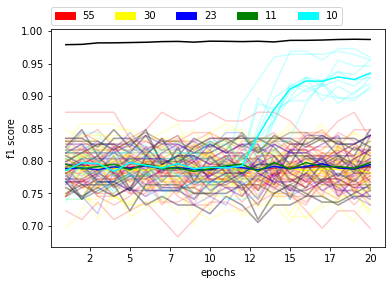

In [51]:
#plotting graphs for loss and accuracies:
#plotting val_loss and loss for the models generated and the benchmark model.
from random import randint
import matplotlib.patches as mpatches
color = ['red', 'yellow','blue', 'green','cyan']
leg=[]
for i in range(len(color)):
    leg.append(mpatches.Patch(color=color[i], label=str(len(val_acc[i]))))
n = len(val_acc)
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(val_acc[i])):
        plt.plot(x_axis,val_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis, np.mean(val_acc[i], axis=0), color=color[i])
#plt.xlim(-0.5,20.5)
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.plot(x_axis, benchmark_val_acc, color='black')
plt.savefig("fig/SKIN_NONSKIN_F1_Val_20Epochs.jpeg")

[0.7539618, 0.7849999, 0.7849999, 0.7849999, 0.7849999, 0.7849999, 0.7849999, 0.7849999, 0.7849999, 0.7849999, 0.7849999, 0.77374995, 0.8262499, 0.87749994, 0.8999999, 0.91125, 0.91374993, 0.9225, 0.9237499, 0.925]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
0 13
0 14
0 15
0 16
0 17
0 18
0 19
0 20
0 21
0 22
0 23
0 24
0 25
0 26
0 27
0 28
0 29
0 30
0 31
0 32
0 33
0 34
0 35
0 36
0 37
0 38
0 39
0 40
0 41
0 42
0 43
0 44
0 45
0 46
0 47
0 48
0 49
0 50
0 51
0 52
0 53
0 54
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
1 11
1 12
1 13
1 14
1 15
1 16
1 17
1 18
1 19
1 20
1 21
1 22
1 23
1 24
1 25
1 26
1 27
1 28
1 29
2 0
2 1
2 2
2 3
2 4
2 5
2 6
2 7
2 8
2 9
2 10
2 11
2 12
2 13
2 14
2 15
2 16
2 17
2 18
2 19
2 20
2 21
2 22
3 0
3 1
3 2
3 3
3 4
3 5
3 6
3 7
3 8
3 9
3 10
4 0
4 1
4 2
4 3
4 4
4 5
4 6
4 7
4 8
4 9


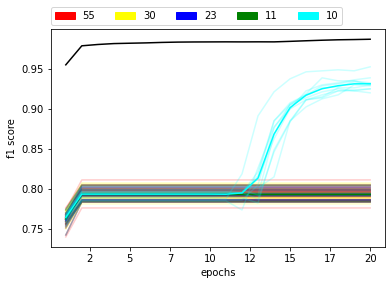

In [52]:
#train accuracy 
from random import randint
color = []
print(train_acc[4][0])
color = ['red', 'yellow','blue', 'green','cyan']
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(train_acc[i])):
        print(i,j)
        plt.plot(x_axis,train_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_acc[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_acc, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/SKIN_NONSKIN_012_F1_train_20Epochs.jpeg")

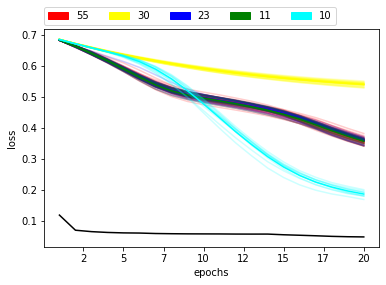

In [53]:
#training loss
from random import randint
color = []
n = len(train_loss)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,train_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/SKIN_NONSKIN_loss_train_20Epochs.jpeg")

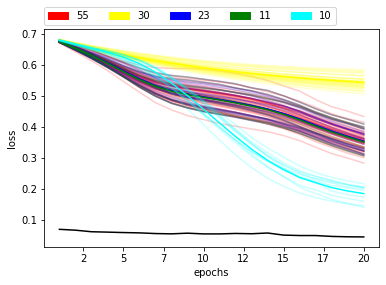

In [54]:
#validation loss loss
from random import randint
color = []
n = len(val_acc)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,val_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(val_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_val_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/SKIN_NONSKIN_loss_val_20Epochs.jpeg")

In [62]:
#from here on trying for epsilon-IP, have updated layer comparison
#for SKIN_NonSkin dataset
dataset = pd.read_csv("Skin_NonSkin.csv",sep=';', names=['x1','x2','x3','label'])
#print(dataset['label'])
scaler = preprocessing.MinMaxScaler()
dataset = pd.DataFrame(scaler.fit_transform(dataset), columns=['x1','x2','x3','label'])
target_variable="label"
print(dataset.head)
Positive=dataset[dataset[target_variable]==0]
Negative=dataset[dataset[target_variable]==1]
print(len(Positive))
print(len(Negative))

<bound method NDFrame.head of               x1        x2        x3  label
0       0.290196  0.333333  0.482353    0.0
1       0.286275  0.329412  0.478431    0.0
2       0.282353  0.325490  0.474510    0.0
3       0.274510  0.317647  0.466667    0.0
4       0.274510  0.317647  0.466667    0.0
...          ...       ...       ...    ...
245052  0.639216  0.635294  0.439216    1.0
245053  0.639216  0.635294  0.439216    1.0
245054  0.639216  0.635294  0.439216    1.0
245055  0.639216  0.635294  0.439216    1.0
245056  1.000000  1.000000  1.000000    1.0

[245057 rows x 4 columns]>
50859
194198


In [63]:
#increasing the size of equal subsample
#the below code is for binary classification since MNSIT is a multi-class low-resolution image dataset. I am updating the code in the next cell.
N=5000
#Positive=Pos
#Negative=Neg
positiveN=int((Positive.shape[0]/dataset.shape[0])*N)
negativeN=int(N-positiveN)
print(positiveN, negativeN)
#target variable
#target_variable="default.payment.next.month"
df1=Positive.sample(positiveN)
Positive.drop(df1.index, inplace=True)
df2=Negative.sample(negativeN)
Negative.drop(df2.index, inplace=True)
test_data=df1.append(df2, ignore_index=True)
test_data=test_data.sample(frac = 1) #This is to shuffel the training and testing data
test_data=test_data.sample(frac = 1)
test_data=test_data.sample(frac = 1)
X_test=test_data.drop(columns=[target_variable])
y_test=to_categorical(test_data[target_variable])

# adding dense layer
initial_model= get_initial_model(X_test.shape[1], 2)
Models=[]
val_acc=[]
train_acc=[]
test_acc=[]
val_loss=[]
train_loss=[]
while Positive.empty==False and Negative.empty==False:
  print(positiveN, negativeN)
  df1=Positive.sample(min(positiveN, len(Positive)))
  Positive.drop(df1.index, inplace=True)
  df2=Negative.sample(min(negativeN, len(Negative)))
  Negative.drop(df2.index, inplace=True)
  train_data=df1.append(df2, ignore_index=True)
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
  train_data=train_data.sample(frac = 1) #shuffel test data 3 times
    
  #all models have different initialization
  # define the sequential model
  """initial_model = keras.Sequential()

    # adding dense layer
  initial_model.add(Dense(5, input_dim=X_test.shape[1], kernel_initializer='normal', activation='relu'))
  initial_model.add(Dense(10, activation='relu'))
  initial_model.add(Dense(5, activation='relu'))

    # adding dense layer with softmax activation/output layer
  initial_model.add(Dense(2, activation='softmax'))
  #initial_model.summary()"""
  ann_model=get_initial_model(X_test.shape[1], 2) #same intial weights
  ann_model.set_weights(initial_model.get_weights())
  X_train=train_data.drop(columns=[target_variable])
  #train_data[target_variable]=train_data[target_variable]-1 #only for skin_nonskin dataset
  y_train=to_categorical(train_data[target_variable])
  #print(y_train)
  ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']
  history = ann_model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=1)
  print(history.history['f1_m'][-1])
  ann_model.set_weights(update_weights(ann_model.get_weights()))
  pred_test=ann_model.predict(X_test)
  present=False
  for i in range(len(Models)):
    if (check_models(Models[i][0], ann_model.get_weights())):
      print("if any")
      Models[i][1]=Models[i][1]+1
      val_acc[i].append(history.history['val_f1_m'])
      train_acc[i].append(history.history['f1_m'])
      test_acc.append(f1_m(y_test, pred_test).numpy())
      val_loss[i].append(history.history['val_loss'])
      train_loss[i].append(history.history['loss'])
      present=True
  if present==False:
    Models.append([ann_model.get_weights(), 1])
    val_acc.append([history.history['val_f1_m']])
    train_acc.append([history.history['f1_m']])
    test_acc.append([f1_m(y_test, pred_test).numpy()])
    val_loss.append([history.history['val_loss']])
    train_loss.append([history.history['loss']])
for i in range(len(Models)):
  print(Models[i][1])
print("All Done")

1037 3963


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


1037 3963
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 175us/sample - loss: 0.6057 - f1_m: 0.7920 - val_loss: 0.5294 - val_f1_m: 0.7969
Epoch 2/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.5080 - f1_m: 0.7920 - val_loss: 0.4781 - val_f1_m: 0.7998
Epoch 3/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.4395 - f1_m: 0.7920 - val_loss: 0.3726 - val_f1_m: 0.7939
Epoch 4/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.3117 - f1_m: 0.7920 - val_loss: 0.2612 - val_f1_m: 0.7939
Epoch 5/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.2423 - f1_m: 0.7920 - val_loss: 0.2202 - val_f1_m: 0.7998
Epoch 6/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2106 - f1_m: 0.8385 - val_loss: 0.1976 - val_f1_m: 0.9365
Epoch 7/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.1907 - f1_m: 0.9315 - val_

Epoch 2/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.5096 - f1_m: 0.7882 - val_loss: 0.4511 - val_f1_m: 0.8145
Epoch 3/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.4216 - f1_m: 0.7882 - val_loss: 0.3222 - val_f1_m: 0.7998
Epoch 4/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2902 - f1_m: 0.7882 - val_loss: 0.2285 - val_f1_m: 0.8086
Epoch 5/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2351 - f1_m: 0.7882 - val_loss: 0.1937 - val_f1_m: 0.8145
Epoch 6/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2079 - f1_m: 0.8745 - val_loss: 0.1738 - val_f1_m: 0.9434
Epoch 7/20
4000/4000 [==============================] - 0s 49us/sample - loss: 0.1900 - f1_m: 0.9305 - val_loss: 0.1598 - val_f1_m: 0.9443
Epoch 8/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.1771 - f1_m: 0.9342 - val_loss: 0.1491 - val_f1_m: 0.9453
Epoch 9/20
4000/4000 [=====

Epoch 15/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.1432 - f1_m: 0.9440 - val_loss: 0.1272 - val_f1_m: 0.9541
Epoch 16/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1417 - f1_m: 0.9438 - val_loss: 0.1258 - val_f1_m: 0.9541
Epoch 17/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1408 - f1_m: 0.9440 - val_loss: 0.1249 - val_f1_m: 0.9541
Epoch 18/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1400 - f1_m: 0.9442 - val_loss: 0.1245 - val_f1_m: 0.9512
Epoch 19/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1393 - f1_m: 0.9442 - val_loss: 0.1233 - val_f1_m: 0.9541
Epoch 20/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1391 - f1_m: 0.9442 - val_loss: 0.1228 - val_f1_m: 0.9551
0.94425
if any
1037 3963
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 170us/sample - loss: 0.6058 

Epoch 5/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2407 - f1_m: 0.7890 - val_loss: 0.2154 - val_f1_m: 0.8057
Epoch 6/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2127 - f1_m: 0.8570 - val_loss: 0.1946 - val_f1_m: 0.9199
Epoch 7/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.1953 - f1_m: 0.9265 - val_loss: 0.1805 - val_f1_m: 0.9209
Epoch 8/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1823 - f1_m: 0.9315 - val_loss: 0.1704 - val_f1_m: 0.9355
Epoch 9/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1732 - f1_m: 0.9312 - val_loss: 0.1639 - val_f1_m: 0.9287
Epoch 10/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.1662 - f1_m: 0.9317 - val_loss: 0.1569 - val_f1_m: 0.9355
Epoch 11/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.1615 - f1_m: 0.9352 - val_loss: 0.1534 - val_f1_m: 0.9355
Epoch 12/20
4000/4000 [==

Epoch 18/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.1417 - f1_m: 0.9442 - val_loss: 0.1308 - val_f1_m: 0.9395
Epoch 19/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1417 - f1_m: 0.9442 - val_loss: 0.1304 - val_f1_m: 0.9453
Epoch 20/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1409 - f1_m: 0.9445 - val_loss: 0.1299 - val_f1_m: 0.9453
0.9445
if any
1037 3963
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 170us/sample - loss: 0.6083 - f1_m: 0.7930 - val_loss: 0.5338 - val_f1_m: 0.7900
Epoch 2/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.4996 - f1_m: 0.7930 - val_loss: 0.4684 - val_f1_m: 0.7900
Epoch 3/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.4058 - f1_m: 0.7930 - val_loss: 0.3331 - val_f1_m: 0.7959
Epoch 4/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2764 - f1

Epoch 8/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.1707 - f1_m: 0.9415 - val_loss: 0.1465 - val_f1_m: 0.9551
Epoch 9/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1606 - f1_m: 0.9448 - val_loss: 0.1373 - val_f1_m: 0.9609
Epoch 10/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1523 - f1_m: 0.9492 - val_loss: 0.1304 - val_f1_m: 0.9639
Epoch 11/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1465 - f1_m: 0.9498 - val_loss: 0.1251 - val_f1_m: 0.9639
Epoch 12/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1419 - f1_m: 0.9520 - val_loss: 0.1205 - val_f1_m: 0.9619
Epoch 13/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1387 - f1_m: 0.9513 - val_loss: 0.1169 - val_f1_m: 0.9658
Epoch 14/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.1360 - f1_m: 0.9515 - val_loss: 0.1140 - val_f1_m: 0.9658
Epoch 15/20
4000/4000 

0.948
1037 3963
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 172us/sample - loss: 0.6079 - f1_m: 0.7890 - val_loss: 0.5141 - val_f1_m: 0.8086
Epoch 2/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.5053 - f1_m: 0.7890 - val_loss: 0.4510 - val_f1_m: 0.7998
Epoch 3/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.4255 - f1_m: 0.7890 - val_loss: 0.3430 - val_f1_m: 0.8086
Epoch 4/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.3064 - f1_m: 0.7890 - val_loss: 0.2505 - val_f1_m: 0.8057
Epoch 5/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2455 - f1_m: 0.7890 - val_loss: 0.2122 - val_f1_m: 0.8027
Epoch 6/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2154 - f1_m: 0.8410 - val_loss: 0.1903 - val_f1_m: 0.9248
Epoch 7/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1961 - f1_m: 0.9243 

Epoch 11/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1607 - f1_m: 0.9402 - val_loss: 0.1485 - val_f1_m: 0.9404
Epoch 12/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1562 - f1_m: 0.9413 - val_loss: 0.1457 - val_f1_m: 0.9453
Epoch 13/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1527 - f1_m: 0.9410 - val_loss: 0.1428 - val_f1_m: 0.9424
Epoch 14/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1503 - f1_m: 0.9417 - val_loss: 0.1408 - val_f1_m: 0.9453
Epoch 15/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.1485 - f1_m: 0.9420 - val_loss: 0.1394 - val_f1_m: 0.9453
Epoch 16/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1468 - f1_m: 0.9415 - val_loss: 0.1384 - val_f1_m: 0.9434
Epoch 17/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1456 - f1_m: 0.9420 - val_loss: 0.1375 - val_f1_m: 0.9453
Epoch 18/20
4000/400

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 172us/sample - loss: 0.6116 - f1_m: 0.7892 - val_loss: 0.5219 - val_f1_m: 0.8018
Epoch 2/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.5054 - f1_m: 0.7892 - val_loss: 0.4550 - val_f1_m: 0.8018
Epoch 3/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.4166 - f1_m: 0.7892 - val_loss: 0.3419 - val_f1_m: 0.8047
Epoch 4/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2950 - f1_m: 0.7892 - val_loss: 0.2563 - val_f1_m: 0.8076
Epoch 5/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2375 - f1_m: 0.7892 - val_loss: 0.2220 - val_f1_m: 0.8047
Epoch 6/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.2082 - f1_m: 0.8675 - val_loss: 0.2026 - val_f1_m: 0.9062
Epoch 7/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.1892 - f1_m: 0.9322 - val_loss: 0.18

Epoch 3/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.4200 - f1_m: 0.7940 - val_loss: 0.3509 - val_f1_m: 0.7920
Epoch 4/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.2921 - f1_m: 0.7940 - val_loss: 0.2589 - val_f1_m: 0.7920
Epoch 5/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.2344 - f1_m: 0.7940 - val_loss: 0.2219 - val_f1_m: 0.7861
Epoch 6/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.2069 - f1_m: 0.8595 - val_loss: 0.1997 - val_f1_m: 0.9209
Epoch 7/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.1878 - f1_m: 0.9332 - val_loss: 0.1823 - val_f1_m: 0.9395
Epoch 8/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.1742 - f1_m: 0.9365 - val_loss: 0.1707 - val_f1_m: 0.9385
Epoch 9/20
4000/4000 [==============================] - 0s 50us/sample - loss: 0.1640 - f1_m: 0.9380 - val_loss: 0.1598 - val_f1_m: 0.9434
Epoch 10/20
4000/4000 [====

Epoch 16/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.1455 - f1_m: 0.9425 - val_loss: 0.1443 - val_f1_m: 0.9395
Epoch 17/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.1446 - f1_m: 0.9415 - val_loss: 0.1438 - val_f1_m: 0.9414
Epoch 18/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.1438 - f1_m: 0.9415 - val_loss: 0.1435 - val_f1_m: 0.9375
Epoch 19/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.1434 - f1_m: 0.9422 - val_loss: 0.1442 - val_f1_m: 0.9395
Epoch 20/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.1431 - f1_m: 0.9423 - val_loss: 0.1437 - val_f1_m: 0.9307
0.94225
1037 3963
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 171us/sample - loss: 0.6077 - f1_m: 0.7917 - val_loss: 0.5301 - val_f1_m: 0.7979
Epoch 2/20
4000/4000 [==============================] - 0s 47us/sample - loss: 0.5032 - f1_m: 

Epoch 18/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1437 - f1_m: 0.9417 - val_loss: 0.1548 - val_f1_m: 0.9316
Epoch 19/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1429 - f1_m: 0.9423 - val_loss: 0.1554 - val_f1_m: 0.9297
Epoch 20/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1425 - f1_m: 0.9420 - val_loss: 0.1543 - val_f1_m: 0.9316
0.942
1037 3963
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 168us/sample - loss: 0.6029 - f1_m: 0.7952 - val_loss: 0.5426 - val_f1_m: 0.7812
Epoch 2/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.5003 - f1_m: 0.7952 - val_loss: 0.4876 - val_f1_m: 0.7812
Epoch 3/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.4213 - f1_m: 0.7952 - val_loss: 0.3597 - val_f1_m: 0.7812
Epoch 4/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.2921 - f1_m: 0.79

Epoch 20/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1286 - f1_m: 0.9520 - val_loss: 0.1332 - val_f1_m: 0.9463
0.952
1037 3963
Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 197us/sample - loss: 0.6054 - f1_m: 0.7947 - val_loss: 0.5383 - val_f1_m: 0.7861
Epoch 2/20
4000/4000 [==============================] - 0s 57us/sample - loss: 0.5026 - f1_m: 0.7947 - val_loss: 0.4899 - val_f1_m: 0.7861
Epoch 3/20
4000/4000 [==============================] - 0s 48us/sample - loss: 0.4292 - f1_m: 0.7947 - val_loss: 0.3775 - val_f1_m: 0.7891
Epoch 4/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.3014 - f1_m: 0.7947 - val_loss: 0.2764 - val_f1_m: 0.7861
Epoch 5/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.2374 - f1_m: 0.7947 - val_loss: 0.2364 - val_f1_m: 0.7803
Epoch 6/20
4000/4000 [==============================] - 0s 51us/sample - loss: 0.2072 - f1_m: 0.8512

Epoch 10/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1685 - f1_m: 0.9315 - val_loss: 0.1498 - val_f1_m: 0.9385
Epoch 11/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1630 - f1_m: 0.9345 - val_loss: 0.1463 - val_f1_m: 0.9365
Epoch 12/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1589 - f1_m: 0.9355 - val_loss: 0.1415 - val_f1_m: 0.9443
Epoch 13/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1562 - f1_m: 0.9387 - val_loss: 0.1388 - val_f1_m: 0.9492
Epoch 14/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1544 - f1_m: 0.9380 - val_loss: 0.1365 - val_f1_m: 0.9492
Epoch 15/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1520 - f1_m: 0.9390 - val_loss: 0.1351 - val_f1_m: 0.9492
Epoch 16/20
4000/4000 [==============================] - 0s 46us/sample - loss: 0.1510 - f1_m: 0.9390 - val_loss: 0.1339 - val_f1_m: 0.9492
Epoch 17/20
4000/400

Train on 4000 samples, validate on 1000 samples
Epoch 1/20
4000/4000 [==============================] - 1s 174us/sample - loss: 0.6127 - f1_m: 0.7907 - val_loss: 0.5249 - val_f1_m: 0.8018
Epoch 2/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.4988 - f1_m: 0.7907 - val_loss: 0.4559 - val_f1_m: 0.7988
Epoch 3/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.4099 - f1_m: 0.7907 - val_loss: 0.3317 - val_f1_m: 0.8018
Epoch 4/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.2889 - f1_m: 0.7907 - val_loss: 0.2478 - val_f1_m: 0.8018
Epoch 5/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.2348 - f1_m: 0.7907 - val_loss: 0.2133 - val_f1_m: 0.7988
Epoch 6/20
4000/4000 [==============================] - 0s 45us/sample - loss: 0.2079 - f1_m: 0.8702 - val_loss: 0.1925 - val_f1_m: 0.9307
Epoch 7/20
4000/4000 [==============================] - 0s 44us/sample - loss: 0.1898 - f1_m: 0.9302 - val_loss: 0.17

In [64]:
#top 5 recurrent models
#this works for getting sorted recurrent models by frequency
A=np.argsort(np.array(Models).T[1])[::-1][:5]
print(np.array(Models).T[1])
print(A)
temp=list(np.array(Models)[A])
print(temp[2][1])

[1 6 6 3 2 11 13 2 2 2 2 1 1 2 4 2 1 2 1 1 1 1 1]
[ 6  5  1  2 14]
6


/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  after removing the cwd from sys.path.
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tupl

In [65]:
#reducing the metrics lists to top 5 models only
val_acc=list(np.array(val_acc)[A])
test_acc=list(np.array(test_acc)[A])
train_acc=list(np.array(train_acc)[A])
val_loss=list(np.array(val_loss)[A])
train_loss=list(np.array(train_loss)[A])

/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/ayushkv/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


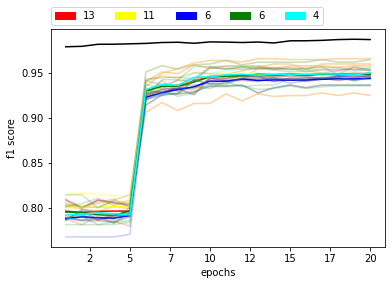

In [66]:
#plotting graphs for loss and accuracies:
#plotting val_loss and loss for the models generated and the benchmark model.
from random import randint
import matplotlib.patches as mpatches
color = ['red', 'yellow','blue', 'green','cyan']
leg=[]
for i in range(len(color)):
    leg.append(mpatches.Patch(color=color[i], label=str(len(val_acc[i]))))
n = len(val_acc)
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(val_acc[i])):
        plt.plot(x_axis,val_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis, np.mean(val_acc[i], axis=0), color=color[i])
#plt.xlim(-0.5,20.5)
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.plot(x_axis, benchmark_val_acc, color='black')
plt.savefig("fig/SKIN_NONSKIN_F1_Val_20Epochs_5000.jpeg")

[0.79324996, 0.79324996, 0.79324996, 0.79324996, 0.79324996, 0.85099995, 0.92999995, 0.93575, 0.93724996, 0.94374996, 0.94725, 0.947, 0.94725, 0.9475, 0.9475, 0.947, 0.9475, 0.94749993, 0.9477499, 0.9475]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
0 0
0 1
0 2
0 3
0 4
0 5
0 6
0 7
0 8
0 9
0 10
0 11
0 12
1 0
1 1
1 2
1 3
1 4
1 5
1 6
1 7
1 8
1 9
1 10
2 0
2 1
2 2
2 3
2 4
2 5
3 0
3 1
3 2
3 3
3 4
3 5
4 0
4 1
4 2
4 3


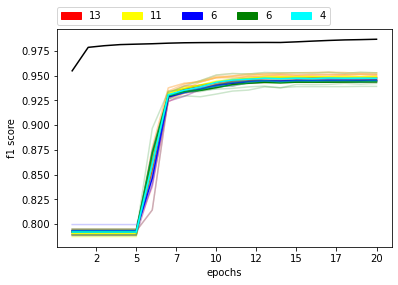

In [67]:
#train accuracy 
from random import randint
color = []
print(train_acc[4][0])
color = ['red', 'yellow','blue', 'green','cyan']
x_axis=np.arange(1, 21, 1)
print(x_axis)
for i in range(n):
    for j in range(len(train_acc[i])):
        print(i,j)
        plt.plot(x_axis,train_acc[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_acc[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_acc, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("f1 score")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/SKIN_NONSKIN_012_F1_train_20Epochs_5000.jpeg")

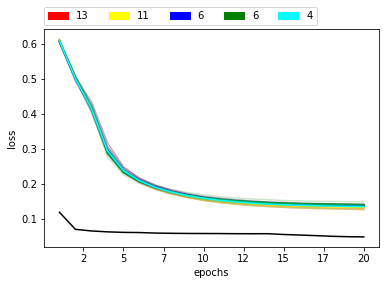

In [68]:
#training loss
from random import randint
color = []
n = len(train_loss)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,train_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/SKIN_NONSKIN_loss_train_20Epochs_5000.jpeg")

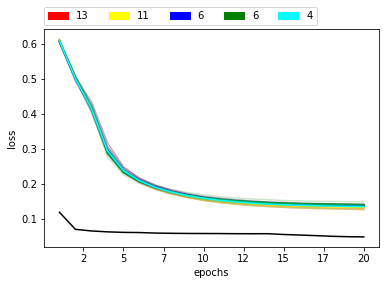

In [69]:
#training loss
from random import randint
color = []
n = len(train_loss)
color = ['red', 'yellow','blue', 'green','cyan']
for i in range(n):
    for j in range(len(train_loss[i])):
        plt.plot(x_axis,train_loss[i][j], color=color[i], alpha=0.2)
    plt.plot(x_axis,np.mean(train_loss[i], axis=0), color=color[i])
plt.plot(x_axis,benchmark_loss, color='black')
plt.xticks([2.5,5.0,7.5,10.0,12.5,15.0,17.5,20.0],[2,5,7,10,12,15,17,20])
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(handles=leg, bbox_to_anchor=(0,1.02,1,0.2), loc="lower left", borderaxespad=0, ncol=5)
plt.savefig("fig/SKIN_NONSKIN_loss_train_20Epochs_5000.jpeg")

In [1]:
print("Hi")

Hi
